Loading Nanostring data...
Loading sample information...
Mapping samples to patient information...
Successfully mapped 58 samples
Dataset contains 269 markers across 58 samples
Sample distribution:
  EXT: 28 samples
  INT: 22 samples
  NON: 8 samples

Performing robust differential expression analysis...
Primary analysis: EXT vs NON...
Analyzed 269 markers (EXT vs NON)
Secondary analysis: EXT vs INT...
Secondary analysis: INT vs NON...
Applying multiple testing correction...
Comprehensive results saved to nanostring_comprehensive_analysis_nature.csv
Creating comprehensive manuscript statistics file...
Manuscript statistics saved to nanostring_manuscript_statistics.csv
Creating summary tables...
Significant genes (p < 0.05) table saved: 21 genes
Creating pathway analysis summary...

MANUSCRIPT-READY SUMMARY STATISTICS
Sample sizes:
  Extreme responders (EXT): 28 samples
  Intermediate responders (INT): 22 samples
  Non-responders (NON): 8 samples

Differential expression analysis (EXT v

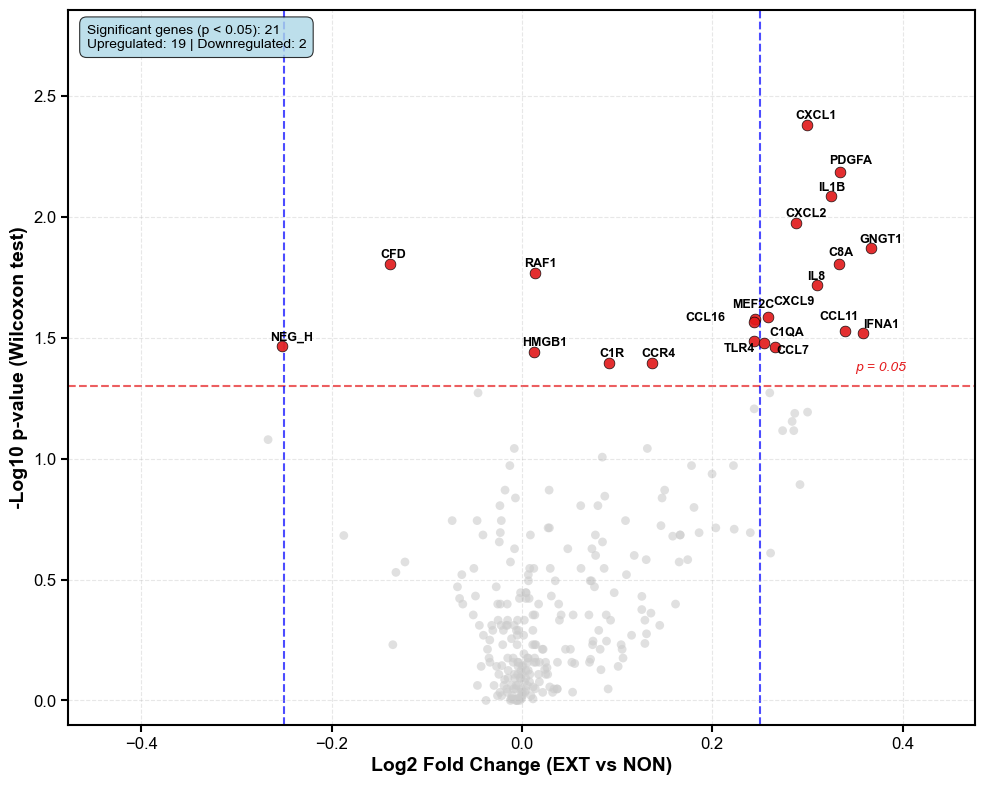

Creating expression heatmap...


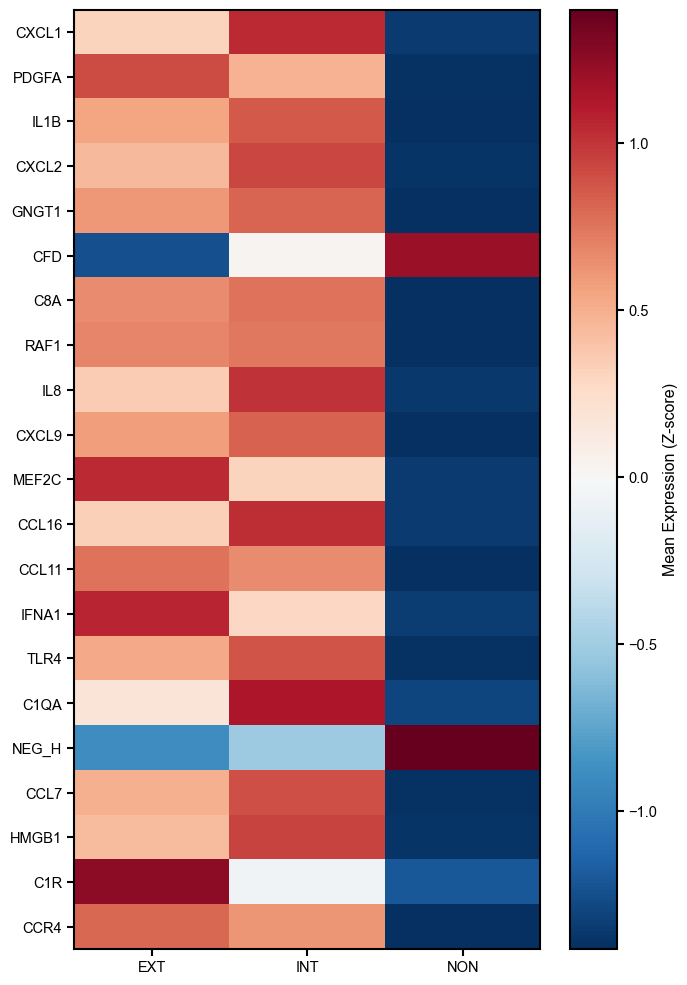

Creating corrected box plots for top markers...
Selected top 6 markers for box plots: CXCL1, PDGFA, IL1B, CXCL2, GNGT1, CFD
Saved corrected box plots

Analysis completed!
Files generated:
  - nanostring_comprehensive_analysis_nature.csv
  - nanostring_volcano_nature.png/.pdf
  - nanostring_heatmap_nature.png/.pdf

METHODS SUMMARY FOR MANUSCRIPT
Statistical Analysis:
Differential gene expression analysis was performed using the Wilcoxon
rank-sum test (Mann-Whitney U test) to compare expression levels between
extreme responders and non-responders. This non-parametric test was chosen
due to the modest sample sizes and non-normal distribution typical of
clinical gene expression data. Only genes with ≥3 samples per group were
included in the analysis. Multiple testing correction was applied using
the Benjamini-Hochberg false discovery rate (FDR) method. Effect sizes
were calculated using Cohen's d and rank-biserial correlation coefficient.
Statistical significance was set at p < 0.05, with 

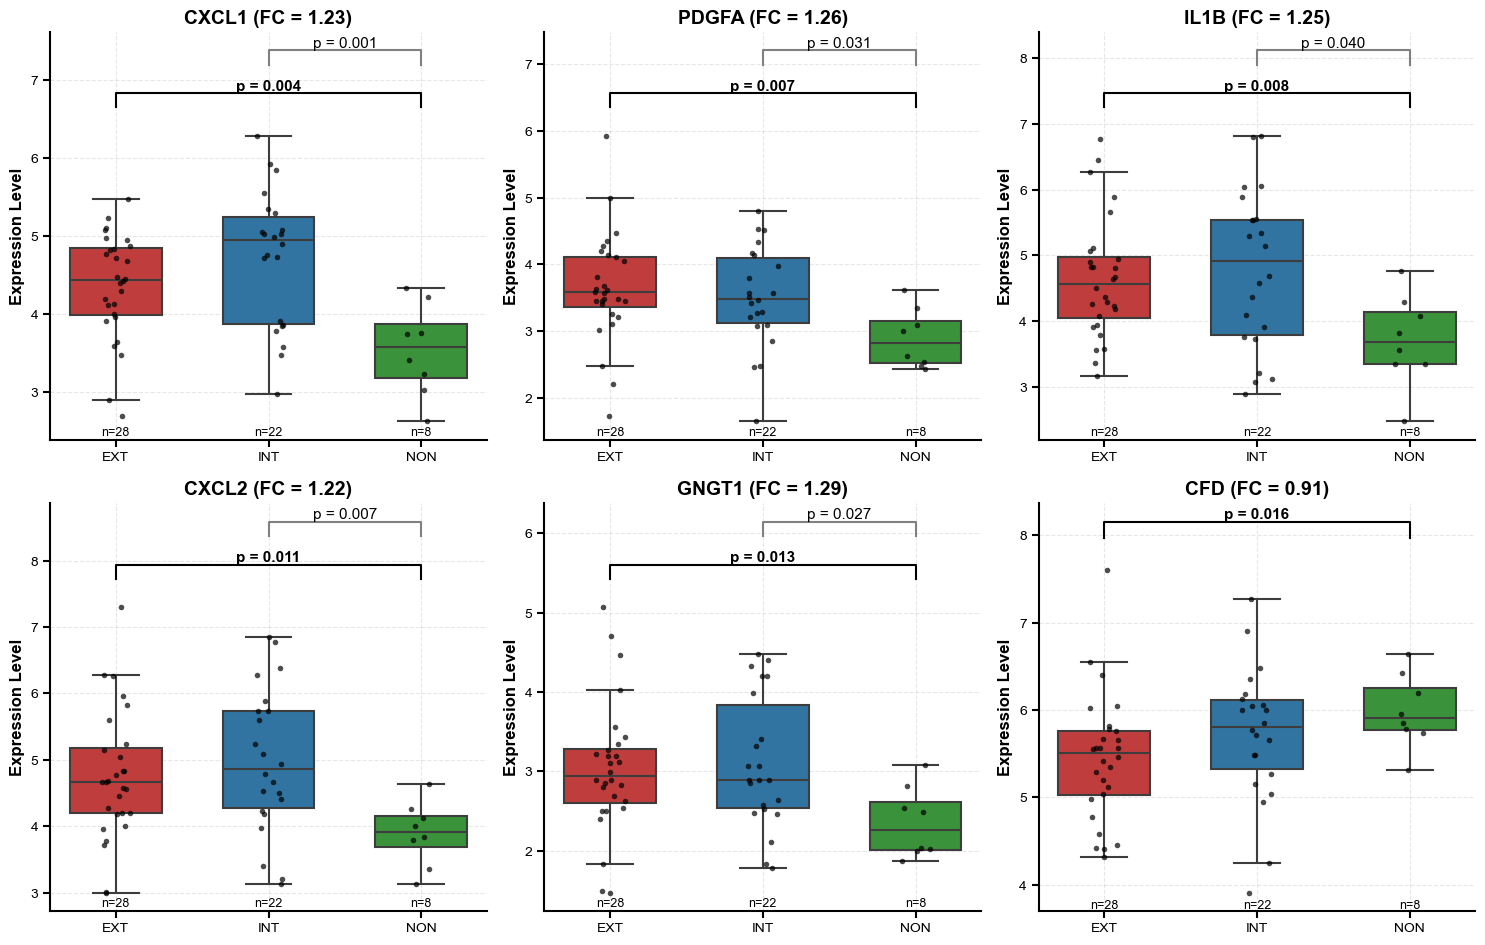

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plot styles
plt.style.use('default')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5

# Custom color palette (Nature-style, colorblind-friendly)
response_colors = {'EXT': '#d62728', 'INT': '#1f77b4', 'NON': '#2ca02c'}

def extract_timepoint(sample_id):
    """Extract timepoint from sample ID"""
    import re
    match = re.search(r'\.([^.]+)$', sample_id)
    if match:
        return match.group(1)
    return None

def robust_differential_analysis(data, marker, group1, group2, sample_groups, min_samples=3):
    """
    Perform robust differential expression analysis using Wilcoxon rank-sum test
    with proper effect size calculations for clinical data
    """
    # Get samples for each group
    group1_cols = [col for col in data.columns if sample_groups.get(col) == group1]
    group2_cols = [col for col in data.columns if sample_groups.get(col) == group2]
    
    # Require minimum sample size for robust statistics
    if len(group1_cols) < min_samples or len(group2_cols) < min_samples:
        return None
    
    # Get expression values and handle missing data
    group1_vals = data.loc[marker, group1_cols].values.astype(float)
    group2_vals = data.loc[marker, group2_cols].values.astype(float)
    
    # Remove NaN values
    group1_vals = group1_vals[~np.isnan(group1_vals)]
    group2_vals = group2_vals[~np.isnan(group2_vals)]
    
    # Check if we still have enough samples after removing NaNs
    if len(group1_vals) < min_samples or len(group2_vals) < min_samples:
        return None
    
    # Calculate robust statistics
    mean_group1 = np.mean(group1_vals)
    mean_group2 = np.mean(group2_vals)
    median_group1 = np.median(group1_vals)
    median_group2 = np.median(group2_vals)
    
    # Calculate effect sizes
    mean_difference = mean_group1 - mean_group2
    true_fold_change = mean_group1 / mean_group2 if mean_group2 > 0 else np.nan
    log2_fold_change = np.log2(true_fold_change) if true_fold_change > 0 else np.nan
    
    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt(((len(group1_vals) - 1) * np.var(group1_vals, ddof=1) + 
                         (len(group2_vals) - 1) * np.var(group2_vals, ddof=1)) / 
                        (len(group1_vals) + len(group2_vals) - 2))
    cohens_d = mean_difference / pooled_std if pooled_std > 0 else np.nan
    
    # Perform Wilcoxon rank-sum test (Mann-Whitney U)
    try:
        statistic, p_val = mannwhitneyu(group1_vals, group2_vals, alternative='two-sided')
        
        # Calculate rank-biserial correlation (effect size for Mann-Whitney U)
        n1, n2 = len(group1_vals), len(group2_vals)
        rank_biserial_r = 1 - (2 * statistic) / (n1 * n2)
        
    except ValueError:
        # Handle cases where all values are identical
        p_val = 1.0
        statistic = np.nan
        rank_biserial_r = 0.0
    
    return {
        'p_value': p_val,
        'statistic': statistic,
        'mean_difference': mean_difference,
        'true_fold_change': true_fold_change,
        'log2_fold_change': log2_fold_change,
        'cohens_d': cohens_d,
        'rank_biserial_r': rank_biserial_r,
        'mean_group1': mean_group1,
        'mean_group2': mean_group2,
        'median_group1': median_group1,
        'median_group2': median_group2,
        'std_group1': np.std(group1_vals, ddof=1),
        'std_group2': np.std(group2_vals, ddof=1),
        'sem_group1': stats.sem(group1_vals),
        'sem_group2': stats.sem(group2_vals),
        'n_group1': len(group1_vals),
        'n_group2': len(group2_vals)
    }

# Load and process data
print("Loading Nanostring data...")
nanostring_df = pd.read_csv('nanostring_data.csv')

print("Loading sample information...")
sample_info_df = pd.read_csv('sample_info.csv', quotechar='"')

# Clean up column names and values
sample_info_df.columns = sample_info_df.columns.str.strip('"')
for col in sample_info_df.columns:
    if sample_info_df[col].dtype == 'object':
        sample_info_df[col] = sample_info_df[col].str.strip('"')

# Define valid response categories
valid_responses = ['EXT', 'INT', 'NON']

# Create comprehensive sample mapping
sample_to_response = {}
sample_to_patientid = {}
sample_to_timepoint = {}
sample_columns = nanostring_df.columns[3:]  # Skip first 3 columns

print("Mapping samples to patient information...")
for _, row in sample_info_df.iterrows():
    if pd.notna(row['Sample #s']) and pd.notna(row['Response (Extreme, Intermediate, Non)']):
        samples = row['Sample #s'].split(',')
        patient_id = row['ID']
        response = row['Response (Extreme, Intermediate, Non)']
        
        if response in valid_responses:
            for sample in samples:
                sample = sample.strip()
                if sample in sample_columns:
                    sample_to_response[sample] = response
                    sample_to_patientid[sample] = patient_id
                    sample_to_timepoint[sample] = extract_timepoint(sample)

print(f"Successfully mapped {len(sample_to_response)} samples")

# Prepare expression data
marker_data = nanostring_df.set_index('Marker Name')
marker_data = marker_data.drop(['Accession', 'Code.Class'], axis=1)

# Ensure all data is numeric
for col in marker_data.columns:
    marker_data[col] = pd.to_numeric(marker_data[col], errors='coerce')

# Filter to valid samples only
valid_samples = [col for col in marker_data.columns if col in sample_to_response]
filtered_data = marker_data[valid_samples]

print(f"Dataset contains {len(filtered_data)} markers across {len(valid_samples)} samples")
print("Sample distribution:")
for response in valid_responses:
    count = sum(1 for s in valid_samples if sample_to_response.get(s) == response)
    print(f"  {response}: {count} samples")


#######################################################################################    
    
# Perform comprehensive differential expression analysis
print("\nPerforming robust differential expression analysis...")

# Primary comparison: EXT vs NON
print("Primary analysis: EXT vs NON...")
ext_vs_non_results = {}
for marker in filtered_data.index:
    result = robust_differential_analysis(filtered_data, marker, 'EXT', 'NON', sample_to_response)
    if result:
        ext_vs_non_results[marker] = result

print(f"Analyzed {len(ext_vs_non_results)} markers (EXT vs NON)")

# Secondary comparisons for completeness
print("Secondary analysis: EXT vs INT...")
ext_vs_int_results = {}
for marker in filtered_data.index:
    result = robust_differential_analysis(filtered_data, marker, 'EXT', 'INT', sample_to_response)
    if result:
        ext_vs_int_results[marker] = result

print("Secondary analysis: INT vs NON...")
int_vs_non_results = {}
for marker in filtered_data.index:
    result = robust_differential_analysis(filtered_data, marker, 'INT', 'NON', sample_to_response)
    if result:
        int_vs_non_results[marker] = result

# Create comprehensive results dataframe
results_data = []
for marker in sorted(ext_vs_non_results.keys()):
    row = {'Marker': marker}
    
    # Primary comparison (EXT vs NON)
    if marker in ext_vs_non_results:
        res = ext_vs_non_results[marker]
        row.update({
            'EXT_vs_NON_p_value': res['p_value'],
            'EXT_vs_NON_log2_fold_change': res['log2_fold_change'],
            'EXT_vs_NON_true_fold_change': res['true_fold_change'],
            'EXT_vs_NON_cohens_d': res['cohens_d'],
            'EXT_vs_NON_rank_biserial_r': res['rank_biserial_r'],
            'Mean_EXT': res['mean_group1'],
            'Mean_NON': res['mean_group2'],
            'Median_EXT': res['median_group1'],
            'Median_NON': res['median_group2'],
            'SEM_EXT': res['sem_group1'],
            'SEM_NON': res['sem_group2'],
            'n_EXT': res['n_group1'],
            'n_NON': res['n_group2']
        })
    
    results_data.append(row)

results_df = pd.DataFrame(results_data)

# Multiple testing correction using Benjamini-Hochberg FDR
print("Applying multiple testing correction...")
p_values = results_df['EXT_vs_NON_p_value'].values
rejected, p_adjusted, alpha_sidak, alpha_bonf = multipletests(p_values, alpha=0.05, method='fdr_bh')

results_df['EXT_vs_NON_p_adjusted'] = p_adjusted
results_df['EXT_vs_NON_significant_raw'] = results_df['EXT_vs_NON_p_value'] < 0.05
results_df['EXT_vs_NON_significant_FDR'] = rejected

# Sort by p-value
results_df = results_df.sort_values('EXT_vs_NON_p_value')

# Summary statistics
n_sig_raw = sum(results_df['EXT_vs_NON_significant_raw'])
n_sig_fdr = sum(results_df['EXT_vs_NON_significant_FDR'])

# Save comprehensive results
results_df.to_csv('nanostring_comprehensive_analysis_nature.csv', index=False)
print("Comprehensive results saved to nanostring_comprehensive_analysis_nature.csv")

# Create a comprehensive manuscript-ready statistics file
print("Creating comprehensive manuscript statistics file...")

# Get all comparisons data
manuscript_data = []
for marker in sorted(ext_vs_non_results.keys()):
    row = {'Marker': marker}
    
    # EXT vs NON (primary comparison)
    if marker in ext_vs_non_results:
        res = ext_vs_non_results[marker]
        row.update({
            'EXT_vs_NON_p_value': res['p_value'],
            'EXT_vs_NON_p_adjusted': results_df[results_df['Marker'] == marker]['EXT_vs_NON_p_adjusted'].iloc[0],
            'EXT_vs_NON_significant_raw': res['p_value'] < 0.05,
            'EXT_vs_NON_significant_FDR': results_df[results_df['Marker'] == marker]['EXT_vs_NON_significant_FDR'].iloc[0],
            'EXT_vs_NON_log2_fold_change': res['log2_fold_change'],
            'EXT_vs_NON_true_fold_change': res['true_fold_change'],
            'EXT_vs_NON_effect_size_cohens_d': res['cohens_d'],
            'EXT_vs_NON_effect_size_rank_biserial': res['rank_biserial_r'],
            'Mean_EXT': res['mean_group1'],
            'Mean_NON': res['mean_group2'],
            'Median_EXT': res['median_group1'],
            'Median_NON': res['median_group2'],
            'SEM_EXT': res['sem_group1'],
            'SEM_NON': res['sem_group2'],
            'SD_EXT': res['std_group1'],
            'SD_NON': res['std_group2'],
            'n_EXT': res['n_group1'],
            'n_NON': res['n_group2']
        })
    
    # EXT vs INT (secondary comparison)
    if marker in ext_vs_int_results:
        res = ext_vs_int_results[marker]
        row.update({
            'EXT_vs_INT_p_value': res['p_value'],
            'EXT_vs_INT_significant': res['p_value'] < 0.05,
            'EXT_vs_INT_log2_fold_change': res['log2_fold_change'],
            'EXT_vs_INT_true_fold_change': res['true_fold_change'],
            'Mean_INT': res['mean_group2'],
            'Median_INT': res['median_group2'],
            'SEM_INT': res['sem_group2'],
            'SD_INT': res['std_group2'],
            'n_INT': res['n_group2']
        })
    
    # INT vs NON (secondary comparison)
    if marker in int_vs_non_results:
        res = int_vs_non_results[marker]
        row.update({
            'INT_vs_NON_p_value': res['p_value'],
            'INT_vs_NON_significant': res['p_value'] < 0.05,
            'INT_vs_NON_log2_fold_change': res['log2_fold_change'],
            'INT_vs_NON_true_fold_change': res['true_fold_change']
        })
    
    manuscript_data.append(row)

manuscript_df = pd.DataFrame(manuscript_data)
manuscript_df = manuscript_df.sort_values('EXT_vs_NON_p_value')

# Add interpretation columns for easy manuscript writing
manuscript_df['Direction_EXT_vs_NON'] = manuscript_df['EXT_vs_NON_log2_fold_change'].apply(
    lambda x: 'Upregulated in EXT' if x > 0 else 'Downregulated in EXT' if x < 0 else 'No change'
)

# Add effect size interpretation
def interpret_cohens_d(d):
    if pd.isna(d):
        return 'Not calculated'
    abs_d = abs(d)
    if abs_d < 0.2:
        return 'Negligible'
    elif abs_d < 0.5:
        return 'Small'
    elif abs_d < 0.8:
        return 'Medium'
    else:
        return 'Large'

manuscript_df['Effect_Size_Interpretation'] = manuscript_df['EXT_vs_NON_effect_size_cohens_d'].apply(interpret_cohens_d)

# Add fold change interpretation
def interpret_fold_change(fc):
    if pd.isna(fc):
        return 'Not calculated'
    if fc > 1.5:
        return f'{fc:.2f}-fold higher in EXT'
    elif fc < 0.67:  # 1/1.5
        return f'{1/fc:.2f}-fold lower in EXT'
    else:
        return f'{fc:.2f}-fold (modest change)'

manuscript_df['Fold_Change_Interpretation'] = manuscript_df['EXT_vs_NON_true_fold_change'].apply(interpret_fold_change)

# Save comprehensive manuscript file
manuscript_df.to_csv('nanostring_manuscript_statistics.csv', index=False)
print("Manuscript statistics saved to nanostring_manuscript_statistics.csv")

# Create summary tables for different significance levels
print("Creating summary tables...")

# Table 1: All significant genes (p < 0.05)
sig_genes_raw = manuscript_df[manuscript_df['EXT_vs_NON_significant_raw']].copy()
sig_genes_raw = sig_genes_raw.sort_values('EXT_vs_NON_p_value')

summary_sig_raw = sig_genes_raw[['Marker', 'EXT_vs_NON_p_value', 'EXT_vs_NON_log2_fold_change', 
                                'EXT_vs_NON_true_fold_change', 'Direction_EXT_vs_NON', 
                                'Effect_Size_Interpretation', 'Mean_EXT', 'Mean_NON', 
                                'n_EXT', 'n_NON']].copy()

summary_sig_raw.to_csv('nanostring_significant_genes_p05.csv', index=False)
print(f"Significant genes (p < 0.05) table saved: {len(summary_sig_raw)} genes")

# Table 2: FDR-significant genes (if any)
if n_sig_fdr > 0:
    sig_genes_fdr = manuscript_df[manuscript_df['EXT_vs_NON_significant_FDR']].copy()
    sig_genes_fdr = sig_genes_fdr.sort_values('EXT_vs_NON_p_value')
    
    summary_sig_fdr = sig_genes_fdr[['Marker', 'EXT_vs_NON_p_value', 'EXT_vs_NON_p_adjusted', 
                                    'EXT_vs_NON_log2_fold_change', 'EXT_vs_NON_true_fold_change', 
                                    'Direction_EXT_vs_NON', 'Effect_Size_Interpretation', 
                                    'Mean_EXT', 'Mean_NON']].copy()
    
    summary_sig_fdr.to_csv('nanostring_significant_genes_fdr05.csv', index=False)
    print(f"FDR-significant genes table saved: {len(summary_sig_fdr)} genes")

# Create pathway analysis summary with proper statistical testing
print("Creating pathway analysis summary...")

def perform_pathway_enrichment_analysis(results_df, pathway_definitions, alpha=0.05):
    """
    Perform hypergeometric test for pathway enrichment analysis
    Suitable for Nature Medicine publication standards
    """
    
    # Get all tested genes
    all_genes = set(results_df['Marker'].values)
    
    # Get significant genes based on raw p-value
    sig_genes = set(results_df[results_df['EXT_vs_NON_significant_raw']]['Marker'].values)
    sig_up = set(results_df[(results_df['EXT_vs_NON_significant_raw']) & 
                            (results_df['EXT_vs_NON_log2_fold_change'] > 0)]['Marker'].values)
    sig_down = set(results_df[(results_df['EXT_vs_NON_significant_raw']) & 
                              (results_df['EXT_vs_NON_log2_fold_change'] < 0)]['Marker'].values)
    
    enrichment_results = []
    
    for pathway_name, pathway_genes in pathway_definitions.items():
        # Get pathway genes that are in our tested set
        pathway_in_data = set(pathway_genes).intersection(all_genes)
        
        if len(pathway_in_data) == 0:
            continue
            
        # Calculate enrichment for all significant genes
        sig_in_pathway = sig_genes.intersection(pathway_in_data)
        
        # Hypergeometric test parameters
        M = len(all_genes)  # Population size (all tested genes)
        n = len(pathway_in_data)  # Number of pathway genes in population
        N = len(sig_genes)  # Number of draws (significant genes)
        k = len(sig_in_pathway)  # Number of successes (sig genes in pathway)
        
        # Perform hypergeometric test (one-tailed, testing for over-representation)
        if N > 0 and n > 0:
            # Calculate p-value for enrichment
            p_value = stats.hypergeom.sf(k-1, M, n, N)
            
            # Calculate fold enrichment
            expected = (n * N) / M
            fold_enrichment = k / expected if expected > 0 else 0
            
            # Get up and down regulated genes in pathway
            up_in_pathway = sig_up.intersection(pathway_in_data)
            down_in_pathway = sig_down.intersection(pathway_in_data)
            
            # Calculate enrichment score (like GSEA)
            if len(sig_in_pathway) > 0:
                # Get fold changes for genes in pathway
                pathway_fc = results_df[results_df['Marker'].isin(sig_in_pathway)]['EXT_vs_NON_log2_fold_change'].values
                enrichment_score = np.mean(np.abs(pathway_fc)) * np.sqrt(len(sig_in_pathway))
            else:
                enrichment_score = 0
            
            enrichment_results.append({
                'Pathway': pathway_name,
                'Total_Genes': len(pathway_in_data),
                'Sig_Genes': k,
                'Sig_Up': len(up_in_pathway),
                'Sig_Down': len(down_in_pathway),
                'Expected': expected,
                'Fold_Enrichment': fold_enrichment,
                'P_Value': p_value,
                'Enrichment_Score': enrichment_score,
                'Sig_Gene_Names': list(sig_in_pathway),
                'Up_Gene_Names': list(up_in_pathway),
                'Down_Gene_Names': list(down_in_pathway)
            })
    
    # Create DataFrame and apply multiple testing correction
    enrichment_df = pd.DataFrame(enrichment_results)
    
    if len(enrichment_df) > 0:
        # Apply FDR correction
        _, p_adjusted, _, _ = multipletests(enrichment_df['P_Value'].values, 
                                           alpha=alpha, method='fdr_bh')
        enrichment_df['P_Adjusted'] = p_adjusted
        enrichment_df['Significant'] = enrichment_df['P_Value'] < alpha
        enrichment_df['Significant_FDR'] = enrichment_df['P_Adjusted'] < alpha
        
        # Sort by p-value
        enrichment_df = enrichment_df.sort_values('P_Value')
    
    return enrichment_df

# Define immune pathway categories (expanded for Nature Medicine)
immune_pathways = {
    'Cytokine Signaling': ['IL1A', 'IL1B', 'IL2', 'IL4', 'IL5', 'IL6', 'IL7', 'IL8', 'IL9', 'IL10', 
                          'IL11', 'IL12A', 'IL12B', 'IL13', 'IL15', 'IL17A', 'IL18', 'IL21', 'IL22', 'IL23A', 
                          'TNF', 'IFNA1', 'IFNB1', 'IFNG', 'TGFB1', 'TGFB2', 'TGFB3'],
    'Chemokine Signaling': ['CCL2', 'CCL3', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCL11', 'CCL13', 
                           'CCL16', 'CCL17', 'CCL19', 'CCL20', 'CCL21', 'CCL22', 'CCL23', 'CCL24', 
                           'CXCL1', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCL9', 'CXCL10'],
    'Complement System': ['C1QA', 'C1QB', 'C1R', 'C1S', 'C2', 'C3', 'C4A', 'C5', 'C6', 'C7', 'C8A', 
                         'C8B', 'C9', 'CFB', 'CFD', 'MBL2', 'MASP1', 'MASP2'],
    'Innate Immunity': ['TLR1', 'TLR2', 'TLR3', 'TLR4', 'TLR5', 'TLR6', 'TLR7', 'TLR8', 'TLR9', 
                       'NOD1', 'NOD2', 'NLRP3', 'MYD88', 'IRF1', 'IRF3', 'IRF5', 'IRF7'],
    'Signal Transduction': ['JAK1', 'STAT1', 'STAT2', 'STAT3', 'MAPK1', 'MAPK3', 'MAPK8', 'MAPK14', 
                           'PIK3C2G', 'NFKB1', 'RELA', 'RELB', 'JUN', 'FOS', 'CREB1', 'MAP2K1', 'MAP2K4', 'MAP2K6']
}

# Print manuscript-ready summary statistics
print("\n" + "="*80)
print("MANUSCRIPT-READY SUMMARY STATISTICS")
print("="*80)

print(f"Sample sizes:")
print(f"  Extreme responders (EXT): {manuscript_df['n_EXT'].iloc[0]} samples")
print(f"  Intermediate responders (INT): {manuscript_df['n_INT'].iloc[0] if 'n_INT' in manuscript_df.columns else 'N/A'} samples")
print(f"  Non-responders (NON): {manuscript_df['n_NON'].iloc[0]} samples")

print(f"\nDifferential expression analysis (EXT vs NON):")
print(f"  Total genes analyzed: {len(manuscript_df)}")
print(f"  Genes with p < 0.05: {n_sig_raw}")
print(f"  Genes with FDR < 0.05: {n_sig_fdr}")
print(f"  Upregulated in EXT: {sum(sig_genes_raw['EXT_vs_NON_log2_fold_change'] > 0)}")
print(f"  Downregulated in EXT: {sum(sig_genes_raw['EXT_vs_NON_log2_fold_change'] < 0)}")

print(f"\nTop 5 most significant genes (EXT vs NON):")
for i, (_, row) in enumerate(sig_genes_raw.head(5).iterrows(), 1):
    direction = "↑" if row['EXT_vs_NON_log2_fold_change'] > 0 else "↓"
    print(f"  {i}. {row['Marker']} {direction} (p = {row['EXT_vs_NON_p_value']:.4f}, "
          f"FC = {row['EXT_vs_NON_true_fold_change']:.2f})")

# Create a simple pathway summary using the existing immune_pathways definition
print(f"\nPathway enrichment highlights:")
sig_markers_set = set(sig_genes_raw['Marker'].tolist())
for pathway_name, pathway_genes in immune_pathways.items():
    # Count significant genes in this pathway
    genes_in_data = [g for g in pathway_genes if g in filtered_data.index]
    sig_genes_in_pathway = [g for g in genes_in_data if g in sig_markers_set]
    
    if len(genes_in_data) > 0 and len(sig_genes_in_pathway) > 0:
        enrichment_pct = (len(sig_genes_in_pathway) / len(genes_in_data)) * 100
        print(f"  {pathway_name}: {len(sig_genes_in_pathway)}/{len(genes_in_data)} genes "
              f"({enrichment_pct:.1f}%)")

print(f"\nFiles created for manuscript:")
print(f"  - nanostring_manuscript_statistics.csv (comprehensive data)")
print(f"  - nanostring_significant_genes_p05.csv (Table for manuscript)")
if n_sig_fdr > 0:
    print(f"  - nanostring_significant_genes_fdr05.csv (FDR-corrected results)")
print(f"  - nanostring_pathway_enrichment_summary.csv (pathway analysis)")
print(f"  - Volcano plot: nanostring_volcano_nature.png/.pdf")
print(f"  - Heatmap: nanostring_heatmap_nature.png/.pdf")

###################################################################################################

# Create volcano plot
print("\nCreating volcano plot...")

plt.figure(figsize=(10, 8))

# Create custom color scheme for the plot
base_color = '#cccccc'  # Light gray for non-significant points
sig_color = '#e41a1c'   # Red for significant points

# Plot all points
plt.scatter(
    results_df['EXT_vs_NON_log2_fold_change'],
    -np.log10(results_df['EXT_vs_NON_p_value']),
    alpha=0.6,
    s=40,
    color=base_color,
    edgecolor='none',
    zorder=1
)

# Highlight significant markers (raw p < 0.05)
sig_raw = results_df[results_df['EXT_vs_NON_significant_raw']]
plt.scatter(
    sig_raw['EXT_vs_NON_log2_fold_change'],
    -np.log10(sig_raw['EXT_vs_NON_p_value']),
    alpha=0.9,
    s=60,
    color=sig_color,
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

# Highlight FDR-significant markers
sig_fdr = results_df[results_df['EXT_vs_NON_significant_FDR']]
if len(sig_fdr) > 0:
    plt.scatter(
        sig_fdr['EXT_vs_NON_log2_fold_change'],
        -np.log10(sig_fdr['EXT_vs_NON_p_value']),
        alpha=0.9,
        s=70,
        color='darkred',
        edgecolor='black',
        linewidth=0.8,
        zorder=3
    )

# Add horizontal line for p-value threshold
plt.axhline(y=-np.log10(0.05), color='#e41a1c', linestyle='--', alpha=0.7, linewidth=1.5, zorder=0)
plt.text(
    0.35, 
    -np.log10(0.05) + 0.05, 
    'p = 0.05', 
    color='#e41a1c',
    fontsize=10,
    fontstyle='italic',
    verticalalignment='bottom'
)

# Add vertical lines for log2 fold change thresholds
fc_threshold = 0.25
plt.axvline(x=fc_threshold, color='blue', linestyle='--', alpha=0.7, linewidth=1.5, zorder=0)
plt.axvline(x=-fc_threshold, color='blue', linestyle='--', alpha=0.7, linewidth=1.5, zorder=0)

# Label top significant markers with automatic positioning
if len(sig_raw) > 0:
    # Prepare text annotations for all significant markers
    texts = []
    for _, row in sig_raw.iterrows():
        marker = row['Marker']
        x = row['EXT_vs_NON_log2_fold_change']
        y = -np.log10(row['EXT_vs_NON_p_value'])
        
        # Create text annotation
        text = plt.text(
            x, y, marker,
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='bottom',
            zorder=3
        )
        texts.append(text)

    # Use adjustText to automatically adjust label positions without arrows
    try:
        from adjustText import adjust_text
        adjust_text(
            texts,
            expand_points=(2.0, 2.0),  # Expand around points
            expand_text=(1.5, 1.5),    # Expand around text
            expand_objects=(1.2, 1.2), # Expand around other objects
            force_points=(0.5, 0.5),   # Force to move away from points
            force_text=(0.5, 0.5),     # Force to move away from text
            force_objects=(0.2, 0.2),  # Force to move away from other objects
            lim=2000,                  # Maximum iterations
            precision=0.05,            # Precision for overlap detection
            only_move={'points': 'y', 'text': 'xy', 'objects': 'xy'}  # Allow movement in all directions
        )
    except ImportError:
        print("adjustText not available, using simple labeling")
        # Fallback to simple offset labeling if adjustText not available
        for i, text in enumerate(texts):
            x, y = text.get_position()
            text.set_position((x + 0.02, y + 0.05))

plt.xlabel('Log2 Fold Change (EXT vs NON)', fontsize=14, fontweight='bold')
plt.ylabel('-Log10 p-value (Wilcoxon test)', fontsize=14, fontweight='bold')

# Improve axis appearance
plt.grid(alpha=0.3, linestyle='--', zorder=0)

# Set axis limits with some padding for labels
x_range = max(abs(results_df['EXT_vs_NON_log2_fold_change'].min()), 
              abs(results_df['EXT_vs_NON_log2_fold_change'].max()))
y_max = max(-np.log10(results_df['EXT_vs_NON_p_value']))

plt.xlim(-x_range * 1.3, x_range * 1.3)
plt.ylim(-0.1, y_max * 1.2)

# Enhance tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add summary statistics in a more compact format
n_sig_up = sum((sig_raw['EXT_vs_NON_log2_fold_change'] > 0))
n_sig_down = sum((sig_raw['EXT_vs_NON_log2_fold_change'] < 0))
n_total_sig = len(sig_raw)

# Create a single summary box
summary_text = f"Significant genes (p < 0.05): {n_total_sig}\nUpregulated: {n_sig_up} | Downregulated: {n_sig_down}"
if len(sig_fdr) > 0:
    summary_text += f"\nFDR < 0.05: {len(sig_fdr)}"

plt.annotate(summary_text, 
             xy=(0.02, 0.98), xycoords='axes fraction', 
             fontsize=10, ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.8))

plt.tight_layout()
plt.savefig('nanostring_volcano_nature.png', dpi=300, bbox_inches='tight')
plt.savefig('nanostring_volcano_nature.pdf', bbox_inches='tight')
plt.show()


########################################################################################################

# Create expression heatmap for significant markers
if n_sig_raw > 0:
    print("Creating expression heatmap...")
    
    # Get significant markers
    sig_markers = sig_raw['Marker'].tolist()
    
    # Calculate mean expression for each group
    expression_matrix = []
    marker_names = []
    
    for marker in sig_markers:
        if marker in filtered_data.index:
            means = []
            for response in ['EXT', 'INT', 'NON']:  # Order: EXT, INT, NON
                samples = [s for s in valid_samples if sample_to_response.get(s) == response]
                if samples:
                    values = filtered_data.loc[marker, samples].values
                    values = values[~np.isnan(values)]
                    if len(values) > 0:
                        means.append(np.mean(values))
                    else:
                        means.append(np.nan)
                else:
                    means.append(np.nan)
            
            if not any(np.isnan(means)):
                expression_matrix.append(means)
                marker_names.append(marker)
    
    if expression_matrix:
        expression_matrix = np.array(expression_matrix)
        
        # Z-score normalize each row
        expression_matrix_z = np.zeros_like(expression_matrix)
        for i in range(len(marker_names)):
            row = expression_matrix[i, :]
            if np.std(row) > 0:
                expression_matrix_z[i, :] = (row - np.mean(row)) / np.std(row)
            else:
                expression_matrix_z[i, :] = row - np.mean(row)
        
        # Create heatmap with original styling
        plt.figure(figsize=(7, 10))
        im = plt.imshow(expression_matrix_z, aspect='auto', cmap='RdBu_r', interpolation='none')
        
        # Add colorbar
        cbar = plt.colorbar(im)
        cbar.set_label('Mean Expression (Z-score)')
        
        # Add axis labels
        plt.yticks(np.arange(len(marker_names)), marker_names)
        plt.xticks(np.arange(3), ['EXT', 'INT', 'NON'])
        
        plt.tight_layout()
        plt.savefig('nanostring_heatmap_nature.png', dpi=300, bbox_inches='tight')
        plt.savefig('nanostring_heatmap_nature.pdf', bbox_inches='tight')
        plt.show()
        
     
#################################################################
# 2. BOX PLOTS OF KEY INDIVIDUAL MARKERS
#################################################################
print("Creating corrected box plots for top markers...")

# Select top markers based on statistical significance
top_markers = results_df.nsmallest(6, 'EXT_vs_NON_p_value')['Marker'].tolist()
print(f"Selected top {len(top_markers)} markers for box plots: {', '.join(top_markers)}")

# Create a figure with subplots for each marker
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Sample metadata with expression values for plotting
plot_data = []
for marker in top_markers:
    for sample in valid_samples:
        if sample in filtered_data.columns:
            expression = filtered_data.loc[marker, sample]
            response = sample_to_response.get(sample)
            patient = sample_to_patientid.get(sample)
            if not pd.isna(expression) and response in valid_responses:
                plot_data.append({
                    'Marker': marker,
                    'Expression': expression,
                    'Response': response,
                    'Patient': patient
                })

plot_df = pd.DataFrame(plot_data)

# Define the order of response groups for consistent visualization
response_order = ['EXT', 'INT', 'NON']

# Create box plots for each marker with enhanced styling
for i, marker in enumerate(top_markers):
    marker_data = plot_df[plot_df['Marker'] == marker]
    
    # Create the box plot with custom styling
    sns.boxplot(
        x='Response',
        y='Expression',
        data=marker_data,
        palette=response_colors,
        order=response_order,
        ax=axes[i],
        width=0.6,
        linewidth=1.5,
        fliersize=0
    )
    
    # Add individual data points as swarmplot
    sns.stripplot(
        x='Response', 
        y='Expression', 
        data=marker_data,
        order=response_order,
        color='black',
        size=4,
        alpha=0.7,
        ax=axes[i],
        jitter=True
    )
    
    # Get the main comparison result (EXT vs NON)
    ext_non_result = ext_vs_non_results.get(marker)
    ext_int_result = ext_vs_int_results.get(marker)
    int_non_result = int_vs_non_results.get(marker)
    
    # Calculate positions for annotations
    y_max = marker_data['Expression'].max()
    y_min = marker_data['Expression'].min()
    y_range = y_max - y_min
    
    # Add EXT vs NON comparison (main comparison)
    if ext_non_result:
        x1, x2 = 0, 2  # positions for EXT and NON
        y_pos = y_max + y_range * 0.1
        h = y_range * 0.05
        axes[i].plot([x1, x1, x2, x2], [y_pos, y_pos+h, y_pos+h, y_pos], lw=1.5, c='black')
        p_text = f"p = {ext_non_result['p_value']:.3f}" if ext_non_result['p_value'] >= 0.001 else "p < 0.001"
        axes[i].text((x1+x2)*.5, y_pos+h, p_text, ha='center', va='bottom', 
                    color='black', fontsize=11, fontweight='bold')
    
    # Add EXT vs INT comparison if significant
    if ext_int_result and ext_int_result['p_value'] < 0.05:
        x1, x2 = 0, 1  # positions for EXT and INT
        y_pos2 = y_max + y_range * 0.25
        h2 = y_range * 0.05
        axes[i].plot([x1, x1, x2, x2], [y_pos2, y_pos2+h2, y_pos2+h2, y_pos2], lw=1.5, c='gray')
        p_text = f"p = {ext_int_result['p_value']:.3f}" if ext_int_result['p_value'] >= 0.001 else "p < 0.001"
        axes[i].text((x1+x2)*.5, y_pos2+h2, p_text, ha='center', va='bottom', 
                    color='black', fontsize=11)
    
    # Add INT vs NON comparison if significant
    if int_non_result and int_non_result['p_value'] < 0.05:
        x1, x2 = 1, 2  # positions for INT and NON
        y_pos3 = y_max + y_range * 0.4 if (ext_int_result and ext_int_result['p_value'] < 0.05) else y_max + y_range * 0.25
        h3 = y_range * 0.05
        axes[i].plot([x1, x1, x2, x2], [y_pos3, y_pos3+h3, y_pos3+h3, y_pos3], lw=1.5, c='gray')
        p_text = f"p = {int_non_result['p_value']:.3f}" if int_non_result['p_value'] >= 0.001 else "p < 0.001"
        axes[i].text((x1+x2)*.5, y_pos3+h3, p_text, ha='center', va='bottom', 
                    color='black', fontsize=11)
    
    # Set title and labels with enhanced styling
    if ext_non_result:
        fc_text = f" (FC = {ext_non_result['true_fold_change']:.2f})"
    else:
        fc_text = ""
    axes[i].set_title(f'{marker}{fc_text}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Expression Level', fontsize=12, fontweight='bold')
    
    # Improve appearance
    axes[i].grid(alpha=0.3, linestyle='--')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    
    # Enhance tick labels
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    
    # Add sample count per group
    for j, resp in enumerate(response_order):
        n = len(marker_data[marker_data['Response'] == resp])
        axes[i].annotate(f"n={n}", xy=(j, y_min - y_range * 0.05), ha='center', fontsize=9)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure in high resolution
plt.savefig('nanostring_top_markers_boxplots_wilcoxon.png', dpi=600, bbox_inches='tight')
plt.savefig('nanostring_top_markers_boxplots_wilcoxon.pdf', bbox_inches='tight')
print("Saved corrected box plots")

print("\nAnalysis completed!")
print("Files generated:")
print("  - nanostring_comprehensive_analysis_nature.csv")
print("  - nanostring_volcano_nature.png/.pdf")
print("  - nanostring_heatmap_nature.png/.pdf")

# Print methods summary for manuscript
print("\n" + "="*60)
print("METHODS SUMMARY FOR MANUSCRIPT")
print("="*60)
print("Statistical Analysis:")
print("Differential gene expression analysis was performed using the Wilcoxon")
print("rank-sum test (Mann-Whitney U test) to compare expression levels between")
print("extreme responders and non-responders. This non-parametric test was chosen")
print("due to the modest sample sizes and non-normal distribution typical of")
print("clinical gene expression data. Only genes with ≥3 samples per group were")
print("included in the analysis. Multiple testing correction was applied using")
print("the Benjamini-Hochberg false discovery rate (FDR) method. Effect sizes")
print("were calculated using Cohen's d and rank-biserial correlation coefficient.")
print("Statistical significance was set at p < 0.05, with FDR < 0.05 for")
print("multiple testing-corrected analyses.")

COMPREHENSIVE TIME-DEPENDENT NANOSTRING ANALYSIS
Loading Nanostring data...
Loading sample information...
Mapping samples to patient and temporal information...
Successfully mapped 58 samples
Samples with valid temporal information: 58
Dataset: 269 markers across 58 samples
PEMBROLIZUMAB + IL-2 STUDY TEMPORAL STRUCTURE
Treatment Phase Distribution:
  Pembrolizumab_IL2: 33 samples (EXT: 15, INT: 12, NON: 6)
  Pembrolizumab_Mono_1: 15 samples (EXT: 7, INT: 7, NON: 1)
  Pembrolizumab_Mono_2: 10 samples (EXT: 6, INT: 3, NON: 1)

Treatment Block Distribution:
  Block 1: 15 samples (EXT: 7, INT: 7, NON: 1)
  Block 2: 33 samples (EXT: 15, INT: 12, NON: 6)
  Block 4: 10 samples (EXT: 6, INT: 3, NON: 1)

Detailed Timepoint Distribution (Block-Week):
  B1W1: 15 samples (EXT: 7, INT: 7, NON: 1)
  B2W2: 16 samples (EXT: 7, INT: 6, NON: 3)
  B2W4: 17 samples (EXT: 8, INT: 6, NON: 3)
  B4W1: 10 samples (EXT: 6, INT: 3, NON: 1)

Longitudinal Structure:
  Total patients: 19
  Patients with multiple ti

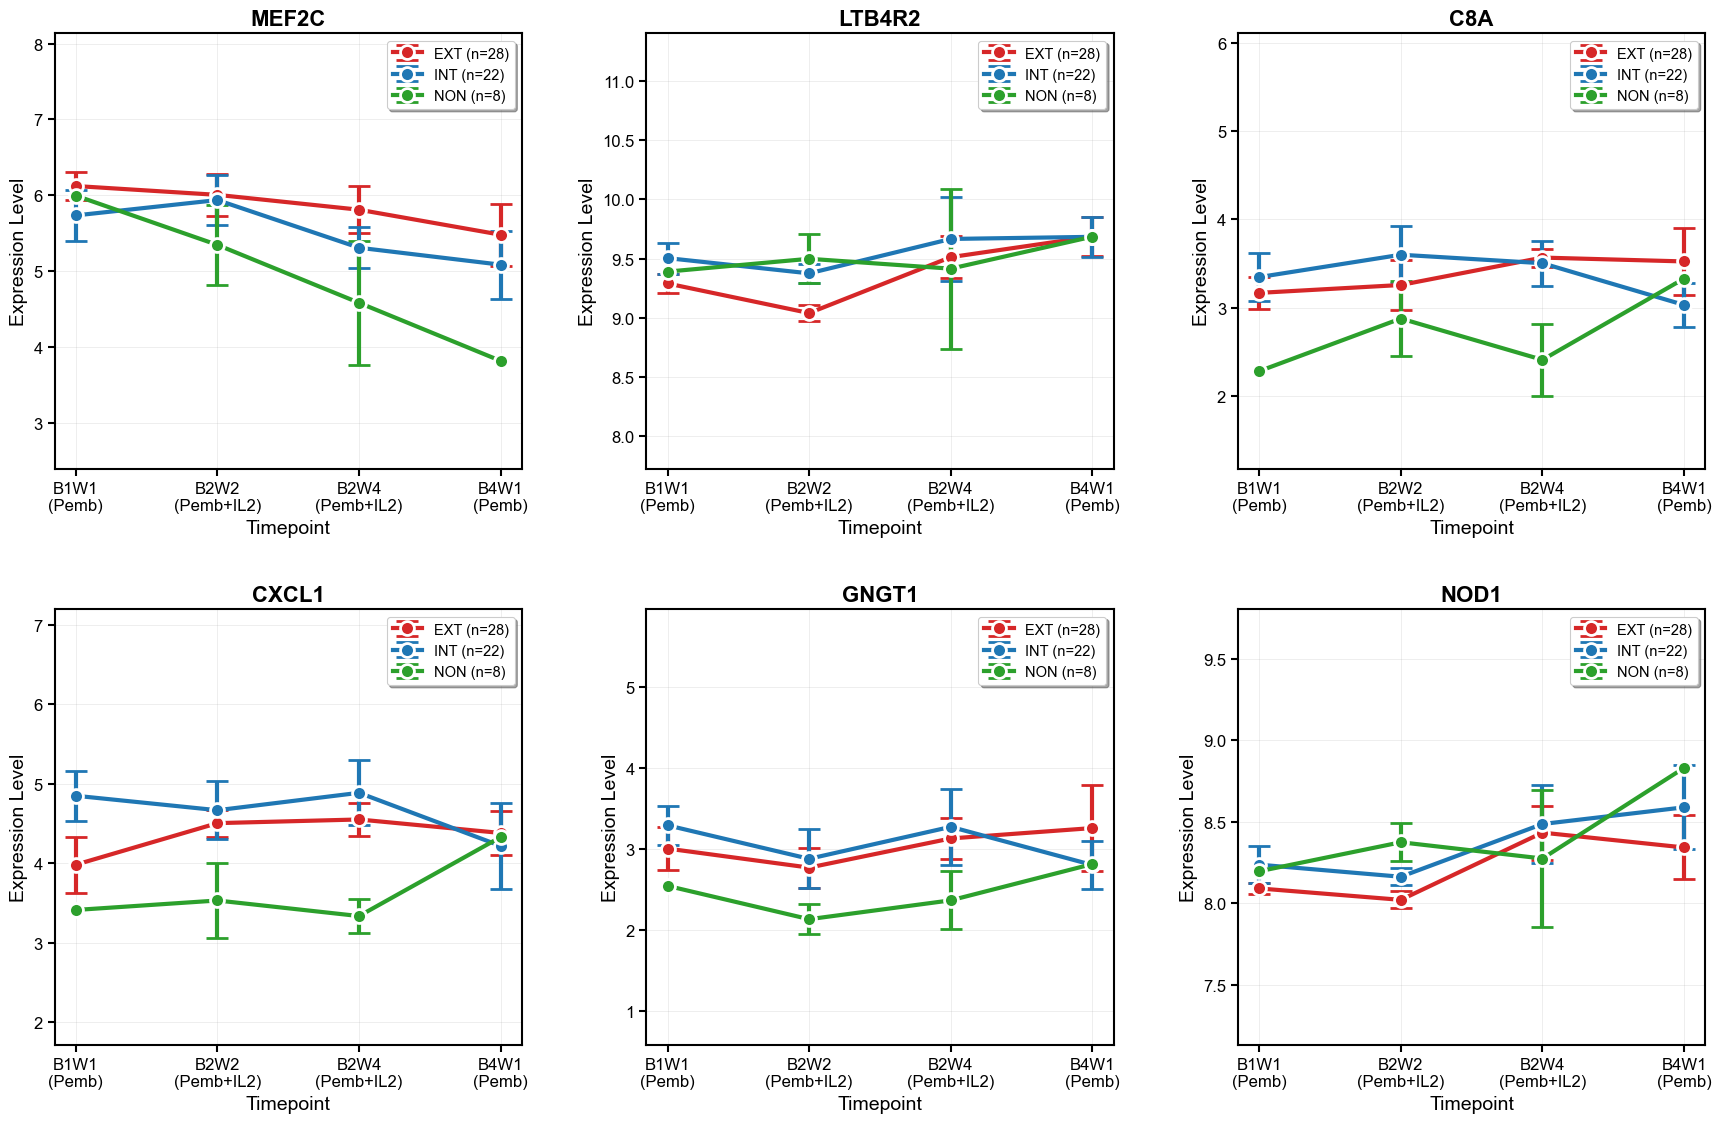

Creating temporal heatmap...
Temporal heatmap saved as PNG and PDF


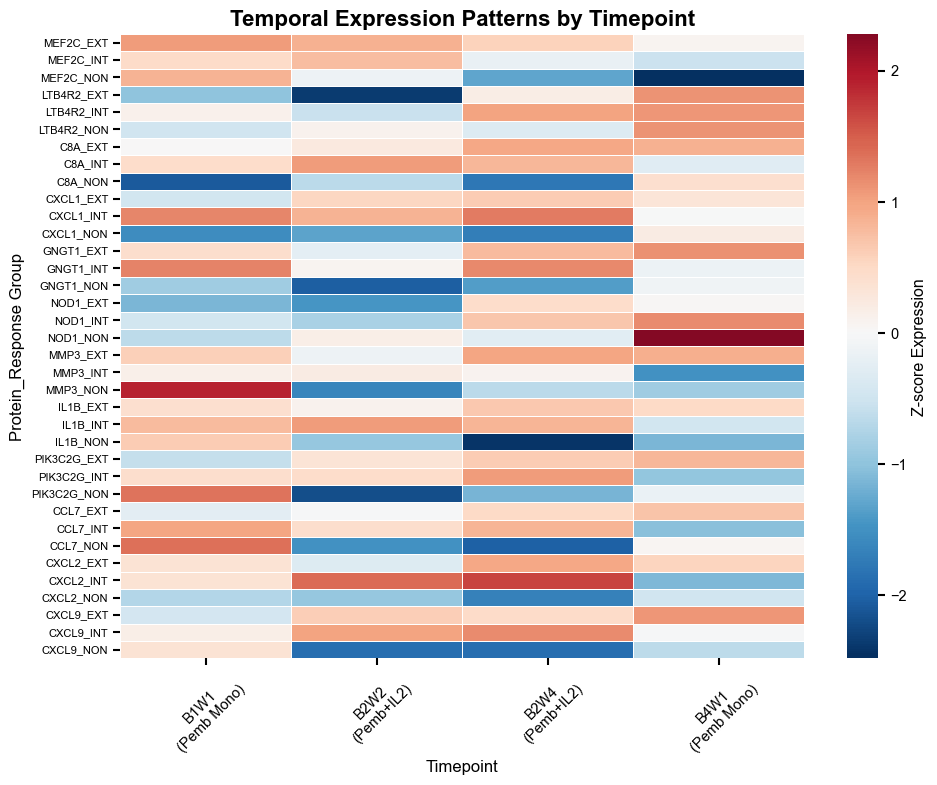


PEMBROLIZUMAB + IL-2 TEMPORAL ANALYSIS SUMMARY

Timepoint Analysis:
  Total marker comparisons: 538
  Significant (p < 0.05): 9
  Significant (FDR < 0.05): 0
    B2W2: 1/269 significant
    B2W4: 8/269 significant

Phase Analysis:
  Total marker comparisons: 269
  Significant (p < 0.05): 15
  Significant (FDR < 0.05): 0
    Pembrolizumab_IL2: 15/269 significant

Block Analysis:
  Total marker comparisons: 269
  Significant (p < 0.05): 15
  Significant (FDR < 0.05): 0
    Block_2: 15/269 significant

Longitudinal Mixed Effects Analysis (269 proteins):
  Model 1 (Study Week Effects):
    Response effects: 0
    Time effects: 51
    Response×Time interactions (EXT): 0
  Model 2 (Treatment Phase Effects):
    IL-2 phase vs Mono phase 1: 0
    Mono phase 2 vs Mono phase 1: 22
  Model 3 (Treatment Block Effects):
    Block effects: 4

Treatment Design Summary:
  Block 1: Pembrolizumab monotherapy
  Blocks 2-3: Pembrolizumab + IL-2 combination
  Block 4: Pembrolizumab monotherapy

Files gene

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import mixedlm
import warnings
import re
warnings.filterwarnings('ignore')

# Set publication-quality plot styles
plt.style.use('default')
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5

# Custom color palette (Nature-style, colorblind-friendly)
response_colors = {'EXT': '#d62728', 'INT': '#1f77b4', 'NON': '#2ca02c'}
timepoint_colors = {'BL': '#8c564b', 'V3': '#e377c2', 'V5': '#7f7f7f', 'EOT': '#bcbd22'}

def extract_timepoint_and_week(sample_id):
    """
    Extract timepoint for pembrolizumab + IL-2 study using blocks and weeks
    Example: FC1D4.007.B1W1 = Subject 007, Block 1 Week 1
    """
    # Parse the sample ID components - focus on block and week
    # Pattern: FC{cycle}D{day}.{subject}.B{block}W{week}
    match = re.match(r'FC\d+D\d+\.(\d+)\.B(\d+)W(\d+)', sample_id)
    
    if match:
        subject = match.group(1)
        block = int(match.group(2))
        week = int(match.group(3))
        
        # Create timepoint identifier using block and week
        timepoint = f"B{block}W{week}"
        
        # Calculate study week based on block and week
        # Block 1: Weeks 1-9 (pembrolizumab monotherapy)
        # Block 2: Weeks 10-18 (pembrolizumab + IL-2)
        # Block 3: Weeks 19-27 (pembrolizumab + IL-2) 
        # Block 4: Weeks 28-36 (pembrolizumab monotherapy)
        
        if block == 1:
            study_week = week
        elif block == 2:
            study_week = 9 + week
        elif block == 3:
            study_week = 18 + week
        elif block == 4:
            study_week = 27 + week
        else:
            study_week = None
        
        # Determine treatment phase
        if block == 1:
            phase = "Pembrolizumab_Mono_1"
        elif block in [2, 3]:
            phase = "Pembrolizumab_IL2"
        elif block == 4:
            phase = "Pembrolizumab_Mono_2"
        else:
            phase = "Unknown"
        
        return {
            'timepoint': timepoint,
            'study_week': study_week,
            'block': block,
            'week_in_block': week,
            'phase': phase,
            'subject': subject
        }
    
    return None

def assess_temporal_structure(sample_temporal_info, sample_to_response):
    """Assess the temporal data structure for pembrolizumab + IL-2 study"""
    
    # Organize by different temporal dimensions
    timepoint_summary = {}  # By block-week
    phase_summary = {}      # By treatment phase
    block_summary = {}      # By treatment block
    patient_timepoint_counts = {}
    
    for sample, temporal_info in sample_temporal_info.items():
        if temporal_info and sample in sample_to_response:
            response = sample_to_response[sample]
            timepoint = temporal_info['timepoint']
            phase = temporal_info['phase']
            block = temporal_info['block']
            subject = temporal_info['subject']
            
            # Track timepoint distribution (Block-Week)
            if timepoint not in timepoint_summary:
                timepoint_summary[timepoint] = {'EXT': 0, 'INT': 0, 'NON': 0}
            timepoint_summary[timepoint][response] += 1
            
            # Track phase distribution
            if phase not in phase_summary:
                phase_summary[phase] = {'EXT': 0, 'INT': 0, 'NON': 0}
            phase_summary[phase][response] += 1
            
            # Track block distribution
            if block not in block_summary:
                block_summary[block] = {'EXT': 0, 'INT': 0, 'NON': 0}
            block_summary[block][response] += 1
            
            # Track patient longitudinal data
            if subject not in patient_timepoint_counts:
                patient_timepoint_counts[subject] = {
                    'timepoints': set(),
                    'blocks': set(),
                    'phases': set(),
                    'study_weeks': set()
                }
            patient_timepoint_counts[subject]['timepoints'].add(timepoint)
            patient_timepoint_counts[subject]['blocks'].add(block)
            patient_timepoint_counts[subject]['phases'].add(phase)
            if temporal_info['study_week']:
                patient_timepoint_counts[subject]['study_weeks'].add(temporal_info['study_week'])
    
    # Assess longitudinal vs cross-sectional structure
    longitudinal_patients = {
        p: len(data['timepoints']) 
        for p, data in patient_timepoint_counts.items() 
        if len(data['timepoints']) > 1
    }
    
    print("PEMBROLIZUMAB + IL-2 STUDY TEMPORAL STRUCTURE")
    print("="*60)
    
    print("Treatment Phase Distribution:")
    for phase, counts in sorted(phase_summary.items()):
        total = sum(counts.values())
        print(f"  {phase}: {total} samples (EXT: {counts['EXT']}, INT: {counts['INT']}, NON: {counts['NON']})")
    
    print("\nTreatment Block Distribution:")
    for block, counts in sorted(block_summary.items()):
        total = sum(counts.values())
        print(f"  Block {block}: {total} samples (EXT: {counts['EXT']}, INT: {counts['INT']}, NON: {counts['NON']})")
    
    print("\nDetailed Timepoint Distribution (Block-Week):")
    for tp in sorted(timepoint_summary.keys()):
        counts = timepoint_summary[tp]
        total = sum(counts.values())
        print(f"  {tp}: {total} samples (EXT: {counts['EXT']}, INT: {counts['INT']}, NON: {counts['NON']})")
    
    print(f"\nLongitudinal Structure:")
    print(f"  Total patients: {len(patient_timepoint_counts)}")
    print(f"  Patients with multiple timepoints: {len(longitudinal_patients)}")
    print(f"  Patients with single timepoint: {len(patient_timepoint_counts) - len(longitudinal_patients)}")
    
    if len(longitudinal_patients) > 0:
        timepoint_dist = list(longitudinal_patients.values())
        print(f"  Average timepoints per longitudinal patient: {np.mean(timepoint_dist):.1f}")
        print(f"  Max timepoints per patient: {max(timepoint_dist)}")
        
        # Analyze treatment progression
        multi_block_patients = sum(1 for data in patient_timepoint_counts.values() if len(data['blocks']) > 1)
        multi_phase_patients = sum(1 for data in patient_timepoint_counts.values() if len(data['phases']) > 1)
        
        print(f"  Patients with multiple treatment blocks: {multi_block_patients}")
        print(f"  Patients with multiple treatment phases: {multi_phase_patients}")
    
    return {
        'timepoint_summary': timepoint_summary,
        'phase_summary': phase_summary, 
        'block_summary': block_summary,
        'patient_timepoint_counts': patient_timepoint_counts,
        'longitudinal_patients': longitudinal_patients
    }

def robust_differential_analysis_temporal(data, marker, group1, group2, sample_groups, 
                                        sample_temporal_info, timepoint=None, phase=None, 
                                        block=None, min_samples=3):
    """
    Enhanced differential analysis with flexible temporal filtering using Wilcoxon rank-sum test
    """
    # Get samples for each group with temporal filtering
    def passes_temporal_filter(sample):
        if sample not in sample_temporal_info:
            return False
        
        temporal_info = sample_temporal_info[sample]
        if timepoint and temporal_info['timepoint'] != timepoint:
            return False
        if phase and temporal_info['phase'] != phase:
            return False
        if block and temporal_info['block'] != block:
            return False
        
        return True
    
    group1_cols = [col for col in data.columns 
                   if sample_groups.get(col) == group1 and passes_temporal_filter(col)]
    group2_cols = [col for col in data.columns 
                   if sample_groups.get(col) == group2 and passes_temporal_filter(col)]
    
    # Require minimum sample size
    if len(group1_cols) < min_samples or len(group2_cols) < min_samples:
        return None
    
    # Get expression values
    group1_vals = data.loc[marker, group1_cols].values.astype(float)
    group2_vals = data.loc[marker, group2_cols].values.astype(float)
    
    # Remove NaN values
    group1_vals = group1_vals[~np.isnan(group1_vals)]
    group2_vals = group2_vals[~np.isnan(group2_vals)]
    
    if len(group1_vals) < min_samples or len(group2_vals) < min_samples:
        return None
    
    # Calculate statistics
    mean_group1 = np.mean(group1_vals)
    mean_group2 = np.mean(group2_vals)
    mean_difference = mean_group1 - mean_group2
    true_fold_change = mean_group1 / mean_group2 if mean_group2 > 0 else np.nan
    log2_fold_change = np.log2(true_fold_change) if true_fold_change > 0 else np.nan
    
    # Cohen's d
    pooled_std = np.sqrt(((len(group1_vals) - 1) * np.var(group1_vals, ddof=1) + 
                         (len(group2_vals) - 1) * np.var(group2_vals, ddof=1)) / 
                        (len(group1_vals) + len(group2_vals) - 2))
    cohens_d = mean_difference / pooled_std if pooled_std > 0 else np.nan
    
    # Wilcoxon rank-sum test (Mann-Whitney U)
    try:
        statistic, p_val = mannwhitneyu(group1_vals, group2_vals, alternative='two-sided')
        n1, n2 = len(group1_vals), len(group2_vals)
        rank_biserial_r = 1 - (2 * statistic) / (n1 * n2)
    except ValueError:
        p_val = 1.0
        statistic = np.nan
        rank_biserial_r = 0.0
    
    return {
        'p_value': p_val,
        'statistic': statistic,
        'mean_difference': mean_difference,
        'true_fold_change': true_fold_change,
        'log2_fold_change': log2_fold_change,
        'cohens_d': cohens_d,
        'rank_biserial_r': rank_biserial_r,
        'mean_group1': mean_group1,
        'mean_group2': mean_group2,
        'std_group1': np.std(group1_vals, ddof=1),
        'std_group2': np.std(group2_vals, ddof=1),
        'sem_group1': stats.sem(group1_vals),
        'sem_group2': stats.sem(group2_vals),
        'n_group1': len(group1_vals),
        'n_group2': len(group2_vals)
    }

def perform_longitudinal_analysis(expression_data, sample_temporal_info, sample_to_response):
    """
    Perform mixed effects analysis for pembrolizumab + IL-2 longitudinal data
    """
    print("Performing mixed effects analysis for pembrolizumab + IL-2 study...")
    
    longitudinal_results = []
    
    for protein in expression_data.index:
        # Prepare data for this protein
        protein_data = []
        for sample in expression_data.columns:
            if (sample in sample_to_response and 
                sample in sample_temporal_info and
                sample_temporal_info[sample] is not None):
                
                temporal_info = sample_temporal_info[sample]
                
                protein_data.append({
                    'expression': expression_data.loc[protein, sample],
                    'patient_id': temporal_info['subject'],
                    'response': sample_to_response[sample],
                    'timepoint': temporal_info['timepoint'],
                    'study_week': temporal_info['study_week'],
                    'block': temporal_info['block'],
                    'phase': temporal_info['phase'],
                    'week_in_block': temporal_info['week_in_block']
                })
        
        df = pd.DataFrame(protein_data).dropna()
        
        # Require minimum sample size and multiple timepoints
        if len(df) > 15 and len(df['study_week'].unique()) > 1:
            try:
                # Model 1: Basic longitudinal model with study week
                model1 = mixedlm("expression ~ C(response) * study_week", 
                               df, groups=df["patient_id"])
                result1 = model1.fit()
                
                # Model 2: Treatment phase model  
                model2 = mixedlm("expression ~ C(response) * C(phase)", 
                               df, groups=df["patient_id"])
                result2 = model2.fit()
                
                # Model 3: Treatment block model
                model3 = mixedlm("expression ~ C(response) * C(block)", 
                               df, groups=df["patient_id"])
                result3 = model3.fit()
                
                # Extract key p-values from each model
                pvals1 = result1.pvalues
                pvals2 = result2.pvalues
                pvals3 = result3.pvalues
                
                longitudinal_results.append({
                    'protein': protein,
                    
                    # Model 1: Study week effects
                    'response_effect_p': pvals1.get('C(response)[T.EXT]', np.nan),
                    'study_week_effect_p': pvals1.get('study_week', np.nan),
                    'interaction_EXT_week_p': pvals1.get('C(response)[T.EXT]:study_week', np.nan),
                    'interaction_INT_week_p': pvals1.get('C(response)[T.INT]:study_week', np.nan),
                    
                    # Model 2: Treatment phase effects
                    'phase_Pemb_IL2_vs_Mono1_p': pvals2.get('C(phase)[T.Pembrolizumab_IL2]', np.nan),
                    'phase_Mono2_vs_Mono1_p': pvals2.get('C(phase)[T.Pembrolizumab_Mono_2]', np.nan),
                    'interaction_EXT_PembIL2_p': pvals2.get('C(response)[T.EXT]:C(phase)[T.Pembrolizumab_IL2]', np.nan),
                    'interaction_EXT_Mono2_p': pvals2.get('C(response)[T.EXT]:C(phase)[T.Pembrolizumab_Mono_2]', np.nan),
                    
                    # Model 3: Treatment block effects
                    'block_effect_p': pvals3.get('C(block)[T.2]', np.nan),  # Block 2 vs Block 1
                    'interaction_EXT_block2_p': pvals3.get('C(response)[T.EXT]:C(block)[T.2]', np.nan),
                    
                    # Model fit statistics
                    'aic_model1': result1.aic,
                    'aic_model2': result2.aic,
                    'aic_model3': result3.aic,
                    'best_model': 1 if result1.aic <= result2.aic and result1.aic <= result3.aic 
                                 else (2 if result2.aic <= result3.aic else 3),
                    
                    # Sample information
                    'n_samples': len(df),
                    'n_patients': len(df['patient_id'].unique()),
                    'n_timepoints': len(df['study_week'].unique()),
                    'n_phases': len(df['phase'].unique()),
                    'n_blocks': len(df['block'].unique()),
                    'converged_all_models': result1.converged and result2.converged and result3.converged
                })
                
            except Exception as e:
                print(f"Error analyzing {protein}: {e}")
                continue
    
    return pd.DataFrame(longitudinal_results)

def time_stratified_analysis(expression_data, sample_to_response, sample_temporal_info, analysis_levels):
    """
    Perform differential expression analysis stratified by blocks and phases
    """
    print("Performing comprehensive time-stratified analysis...")
    
    results = {
        'by_timepoint': {},
        'by_phase': {},
        'by_block': {}
    }
    
    # Analysis by specific timepoints (B1W1, B2W1, etc.)
    available_timepoints = list(set(info['timepoint'] for info in sample_temporal_info.values() if info))
    print(f"  Analyzing by timepoints: {sorted(available_timepoints)}")
    
    for timepoint in sorted(available_timepoints):
        print(f"    Timepoint: {timepoint}")
        
        # Count samples per group at this timepoint
        group_counts = {}
        for sample, temporal_info in sample_temporal_info.items():
            if temporal_info and temporal_info['timepoint'] == timepoint and sample in sample_to_response:
                response = sample_to_response[sample]
                group_counts[response] = group_counts.get(response, 0) + 1
        
        print(f"      Sample distribution: {group_counts}")
        
        if group_counts.get('EXT', 0) >= 3 and group_counts.get('NON', 0) >= 3:
            timepoint_results = {}
            
            for marker in expression_data.index:
                result = robust_differential_analysis_temporal(
                    expression_data, marker, 'EXT', 'NON', 
                    sample_to_response, sample_temporal_info, timepoint=timepoint
                )
                if result:
                    timepoint_results[marker] = result
            
            results['by_timepoint'][timepoint] = timepoint_results
            print(f"      Analyzed {len(timepoint_results)} markers")
    
    # Analysis by treatment phase
    available_phases = list(set(info['phase'] for info in sample_temporal_info.values() if info))
    print(f"  Analyzing by treatment phases: {sorted(available_phases)}")
    
    for phase in sorted(available_phases):
        print(f"    Phase: {phase}")
        
        # Count samples per group in this phase
        group_counts = {}
        for sample, temporal_info in sample_temporal_info.items():
            if temporal_info and temporal_info['phase'] == phase and sample in sample_to_response:
                response = sample_to_response[sample]
                group_counts[response] = group_counts.get(response, 0) + 1
        
        print(f"      Sample distribution: {group_counts}")
        
        if group_counts.get('EXT', 0) >= 3 and group_counts.get('NON', 0) >= 3:
            phase_results = {}
            
            for marker in expression_data.index:
                result = robust_differential_analysis_temporal(
                    expression_data, marker, 'EXT', 'NON', 
                    sample_to_response, sample_temporal_info, phase=phase
                )
                if result:
                    phase_results[marker] = result
            
            results['by_phase'][phase] = phase_results
            print(f"      Analyzed {len(phase_results)} markers")
    
    # Analysis by treatment block
    available_blocks = list(set(info['block'] for info in sample_temporal_info.values() if info))
    print(f"  Analyzing by treatment blocks: {sorted(available_blocks)}")
    
    for block in sorted(available_blocks):
        print(f"    Block: {block}")
        
        # Count samples per group in this block
        group_counts = {}
        for sample, temporal_info in sample_temporal_info.items():
            if temporal_info and temporal_info['block'] == block and sample in sample_to_response:
                response = sample_to_response[sample]
                group_counts[response] = group_counts.get(response, 0) + 1
        
        print(f"      Sample distribution: {group_counts}")
        
        if group_counts.get('EXT', 0) >= 3 and group_counts.get('NON', 0) >= 3:
            block_results = {}
            
            for marker in expression_data.index:
                result = robust_differential_analysis_temporal(
                    expression_data, marker, 'EXT', 'NON', 
                    sample_to_response, sample_temporal_info, block=block
                )
                if result:
                    block_results[marker] = result
            
            results['by_block'][block] = block_results
            print(f"      Analyzed {len(block_results)} markers")
    
    return results

def create_trajectory_plots_timepoints_robust_fix(expression_data, sample_temporal_info, sample_to_response, top_proteins, save_plots=True):
    """
    Create time-course trajectory plots using individual timepoints on x-axis
    COMPREHENSIVE FIX: Ensures ALL data points are visible with proper y-axis calculation
    """
    print("Creating trajectory plots by timepoints with comprehensive y-axis fix...")
    
    n_proteins = min(len(top_proteins), 6)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Define timepoint order and labels
    timepoint_order = ['B1W1', 'B2W2', 'B2W4', 'B4W1']
    timepoint_labels = {
        'B1W1': 'B1W1\n(Pemb)',
        'B2W2': 'B2W2\n(Pemb+IL2)', 
        'B2W4': 'B2W4\n(Pemb+IL2)',
        'B4W1': 'B4W1\n(Pemb)'
    }
    
    for i, protein in enumerate(top_proteins[:n_proteins]):
        # Prepare data for this protein
        plot_data = []
        for sample in expression_data.columns:
            if (sample in sample_to_response and 
                sample in sample_temporal_info and 
                sample_temporal_info[sample] is not None):
                
                temporal_info = sample_temporal_info[sample]
                expression_val = expression_data.loc[protein, sample]
                
                # Only include non-null, non-NaN values
                if pd.notna(expression_val) and not np.isnan(float(expression_val)):
                    plot_data.append({
                        'expression': float(expression_val),
                        'timepoint': temporal_info['timepoint'],
                        'response': sample_to_response[sample],
                        'patient': temporal_info['subject']
                    })
        
        df = pd.DataFrame(plot_data)
        
        if len(df) == 0:
            print(f"No valid data for {protein}, skipping...")
            continue
        
        # COLLECT ALL VALUES THAT WILL BE PLOTTED FOR Y-AXIS CALCULATION
        all_expression_values = df['expression'].tolist()
        print(f"{protein}: Found {len(all_expression_values)} valid expression values")
        print(f"  Raw range: {min(all_expression_values):.3f} to {max(all_expression_values):.3f}")
        
        # Additional values from error bars
        error_bar_values = []
        
        # Plot trajectories by response group
        for response in ['EXT', 'INT', 'NON']:
            response_data = df[df['response'] == response]
            if len(response_data) == 0:
                continue
            
            # Mean trajectory with error bars by timepoint
            mean_data = []
            for tp_idx, timepoint in enumerate(timepoint_order):
                timepoint_data = response_data[response_data['timepoint'] == timepoint]
                if len(timepoint_data) > 0:
                    mean_expr = timepoint_data['expression'].mean()
                    sem_expr = timepoint_data['expression'].sem()
                    n_samples = len(timepoint_data)
                    
                    # Store error bar bounds for y-axis calculation
                    if pd.notna(sem_expr) and sem_expr > 0:
                        error_bar_values.extend([mean_expr - sem_expr, mean_expr + sem_expr])
                    
                    mean_data.append({
                        'timepoint_idx': tp_idx,
                        'timepoint': timepoint,
                        'mean': mean_expr,
                        'sem': sem_expr,
                        'n': n_samples
                    })
            
            if len(mean_data) > 0:
                mean_df = pd.DataFrame(mean_data)
                
                # Plot mean trajectory
                axes[i].errorbar(mean_df['timepoint_idx'], mean_df['mean'],
                               yerr=mean_df['sem'],
                               color=response_colors[response], linewidth=3, 
                               label=f'{response} (n={len(response_data)})', 
                               marker='o', markersize=10, capsize=8,
                               markeredgewidth=2, markeredgecolor='white')
        
        # COMPREHENSIVE Y-AXIS LIMITS CALCULATION
        # Combine all values: raw data + error bar bounds
        all_y_values = all_expression_values + error_bar_values
        
        if all_y_values:
            # Remove any remaining NaN values
            valid_y_values = [v for v in all_y_values if pd.notna(v) and not np.isnan(v)]
            
            if len(valid_y_values) > 0:
                data_min = min(valid_y_values)
                data_max = max(valid_y_values)
                
                print(f"  {protein}: Complete data range (including error bars): {data_min:.3f} to {data_max:.3f}")
                
                # Calculate robust padding
                data_range = data_max - data_min
                
                if data_range > 0:
                    # Use 25% padding to ensure good visibility
                    padding = data_range * 0.25
                else:
                    # For flat data, use absolute padding based on data magnitude
                    avg_magnitude = (abs(data_min) + abs(data_max)) / 2
                    padding = max(avg_magnitude * 0.1, 0.1)
                
                y_min = data_min - padding
                y_max = data_max + padding
                
                print(f"  {protein}: Final y-limits: {y_min:.3f} to {y_max:.3f}")
                
                # Apply the limits
                axes[i].set_ylim(y_min, y_max)
                
            else:
                print(f"  {protein}: No valid y-values found, using default limits")
                axes[i].set_ylim(0, 1)
        else:
            print(f"  {protein}: No y-values to plot, using default limits")  
            axes[i].set_ylim(0, 1)
        
        # Customize plot
        axes[i].set_title(f'{protein}', fontsize=16, fontweight='bold')
        axes[i].set_xlabel('Timepoint', fontsize=14)
        axes[i].set_ylabel('Expression Level', fontsize=14)
        
        # Set x-axis to show timepoints
        axes[i].set_xticks(range(len(timepoint_order)))
        axes[i].set_xticklabels([timepoint_labels[tp] for tp in timepoint_order])
        
        # Add grid for readability
        axes[i].grid(alpha=0.3, linestyle='-', linewidth=0.5)
        
        # Legend
        axes[i].legend(loc='best', frameon=True, fancybox=True, shadow=True)
        
        # Improve tick formatting
        axes[i].tick_params(labelsize=12)
        
        # Verify final axis limits
        final_ylim = axes[i].get_ylim()
        print(f"  {protein}: Applied y-axis limits: {final_ylim[0]:.3f} to {final_ylim[1]:.3f}")
    
    # Remove empty subplots
    for j in range(n_proteins, len(axes)):
        fig.delaxes(axes[j])
    
    # Improve overall layout
    plt.tight_layout(pad=3.0)
        
    if save_plots:
        plt.savefig('nanostring_trajectory_timepoints_fixed.png', dpi=300, bbox_inches='tight')
        plt.savefig('nanostring_trajectory_timepoints_fixed.pdf', bbox_inches='tight')
        print("Fixed trajectory plots saved as PNG and PDF")
    
    plt.show()

def create_temporal_heatmap(expression_data, sample_temporal_info, sample_to_response, significant_proteins, save_plots=True):
    """
    Create heatmap showing expression patterns over specific timepoints by response group
    """
    print("Creating temporal heatmap...")
    
    # Use specific timepoints instead of blocks
    unique_timepoints = ['B1W1', 'B2W2', 'B2W4', 'B4W1']
    
    # Calculate mean expression by timepoint and response
    heatmap_data = []
    row_labels = []
    
    for protein in significant_proteins[:20]:  # Limit to top 20 for readability
        for response in ['EXT', 'INT', 'NON']:
            row_data = []
            for timepoint in unique_timepoints:
                samples = [s for s in sample_to_response.keys() if 
                          sample_to_response[s] == response and 
                          sample_temporal_info.get(s) and
                          sample_temporal_info[s]['timepoint'] == timepoint]
                
                if samples and len(samples) > 0:
                    mean_expr = expression_data.loc[protein, samples].mean()
                    row_data.append(mean_expr)
                else:
                    row_data.append(np.nan)
            
            heatmap_data.append(row_data)
            row_labels.append(f"{protein}_{response}")
    
    # Create heatmap
    plt.figure(figsize=(10, max(8, len(significant_proteins) * 0.6)))
    
    # Convert to numpy array and handle NaNs
    heatmap_array = np.array(heatmap_data)
    
    # Z-score normalize each protein across timepoints
    protein_normalized_data = []
    for i in range(0, len(heatmap_array), 3):  # Every 3 rows is one protein
        protein_data = heatmap_array[i:i+3]
        # Calculate z-score across all timepoints for this protein
        protein_mean = np.nanmean(protein_data)
        protein_std = np.nanstd(protein_data)
        if protein_std > 0:
            protein_normalized = (protein_data - protein_mean) / protein_std
        else:
            protein_normalized = protein_data - protein_mean
        protein_normalized_data.extend(protein_normalized)
    
    normalized_array = np.array(protein_normalized_data)
    
    # Create timepoint labels with treatment info
    timepoint_labels = []
    for timepoint in unique_timepoints:
        if timepoint == 'B1W1':
            timepoint_labels.append(f"{timepoint}\n(Pemb Mono)")
        elif timepoint in ['B2W2', 'B2W4']:
            timepoint_labels.append(f"{timepoint}\n(Pemb+IL2)")
        elif timepoint == 'B4W1':
            timepoint_labels.append(f"{timepoint}\n(Pemb Mono)")
        else:
            timepoint_labels.append(timepoint)
    
    sns.heatmap(normalized_array, 
                xticklabels=timepoint_labels,
                yticklabels=row_labels,
                cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Z-score Expression'},
                linewidths=0.5)
    
    plt.title('Temporal Expression Patterns by Timepoint', fontsize=16, fontweight='bold')
    plt.xlabel('Timepoint', fontsize=12)
    plt.ylabel('Protein_Response Group', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0, fontsize=8)
    
    if save_plots:
        plt.savefig('nanostring_temporal_heatmap.png', dpi=300, bbox_inches='tight')
        plt.savefig('nanostring_temporal_heatmap.pdf', bbox_inches='tight')
        print("Temporal heatmap saved as PNG and PDF")

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN ANALYSIS EXECUTION
# =============================================================================

print("COMPREHENSIVE TIME-DEPENDENT NANOSTRING ANALYSIS")
print("=" * 60)

# Load data (using your existing code structure)
print("Loading Nanostring data...")
nanostring_df = pd.read_csv('nanostring_data.csv')

print("Loading sample information...")
sample_info_df = pd.read_csv('sample_info.csv', quotechar='"')

# Clean up data (your existing preprocessing)
sample_info_df.columns = sample_info_df.columns.str.strip('"')
for col in sample_info_df.columns:
    if sample_info_df[col].dtype == 'object':
        sample_info_df[col] = sample_info_df[col].str.strip('"')

valid_responses = ['EXT', 'INT', 'NON']

# Enhanced sample mapping with temporal information for pembrolizumab + IL-2 study
sample_to_response = {}
sample_to_patientid = {}
sample_temporal_info = {}
sample_columns = nanostring_df.columns[3:]

print("Mapping samples to patient and temporal information...")

for _, row in sample_info_df.iterrows():
    if pd.notna(row['Sample #s']) and pd.notna(row['Response (Extreme, Intermediate, Non)']):
        samples = row['Sample #s'].split(',')
        patient_id = row['ID']
        response = row['Response (Extreme, Intermediate, Non)']
        
        if response in valid_responses:
            for sample in samples:
                sample = sample.strip()
                if sample in sample_columns:
                    sample_to_response[sample] = response
                    sample_to_patientid[sample] = patient_id
                    
                    # Extract temporal information using blocks and weeks
                    temporal_info = extract_timepoint_and_week(sample)
                    sample_temporal_info[sample] = temporal_info

print(f"Successfully mapped {len(sample_to_response)} samples")

# Filter out samples without temporal information
valid_temporal_samples = [s for s in sample_to_response.keys() if sample_temporal_info.get(s)]
print(f"Samples with valid temporal information: {len(valid_temporal_samples)}")

# Prepare expression data
marker_data = nanostring_df.set_index('Marker Name')
marker_data = marker_data.drop(['Accession', 'Code.Class'], axis=1)

for col in marker_data.columns:
    marker_data[col] = pd.to_numeric(marker_data[col], errors='coerce')

valid_samples = [col for col in marker_data.columns if col in sample_to_response]
filtered_data = marker_data[valid_samples]

print(f"Dataset: {len(filtered_data)} markers across {len(valid_samples)} samples")

# STEP 1: Assess temporal data structure for pembrolizumab + IL-2 study
temporal_structure = assess_temporal_structure(sample_temporal_info, sample_to_response)

# STEP 2: Determine analysis strategy based on available data
available_timepoints = list(set(info['timepoint'] for info in sample_temporal_info.values() if info))
available_phases = list(set(info['phase'] for info in sample_temporal_info.values() if info))
available_blocks = list(set(info['block'] for info in sample_temporal_info.values() if info))

print(f"\nAvailable timepoints: {sorted(available_timepoints)}")
print(f"Available treatment phases: {sorted(available_phases)}")
print(f"Available treatment blocks: {sorted(available_blocks)}")

# STEP 3: Perform comprehensive time-stratified analysis
analysis_levels = {
    'timepoints': available_timepoints,
    'phases': available_phases, 
    'blocks': available_blocks
}

results_stratified = time_stratified_analysis(
    filtered_data, sample_to_response, sample_temporal_info, analysis_levels
)

# STEP 4: Perform longitudinal analysis (if sufficient longitudinal data)
longitudinal_patients = temporal_structure['longitudinal_patients']
if len(longitudinal_patients) > 5:
    print(f"\nSufficient longitudinal data detected ({len(longitudinal_patients)} patients)")
    longitudinal_results = perform_longitudinal_analysis(
        filtered_data, sample_temporal_info, sample_to_response
    )
    
    # Save longitudinal results
    if len(longitudinal_results) > 0:
        longitudinal_results.to_csv('nanostring_longitudinal_analysis.csv', index=False)
        print("Longitudinal analysis results saved")
else:
    print(f"\nInsufficient longitudinal data ({len(longitudinal_patients)} patients), focusing on time-stratified analysis")
    longitudinal_results = pd.DataFrame()

# STEP 5: Compile comprehensive results across all temporal levels
print("\nCompiling comprehensive temporal results...")

# Create master results dataframe
all_temporal_results = []

# Results by timepoint
for timepoint, timepoint_results in results_stratified['by_timepoint'].items():
    for marker, result in timepoint_results.items():
        temporal_info = next((info for info in sample_temporal_info.values() 
                            if info and info['timepoint'] == timepoint), None)
        
        row = {
            'Marker': marker,
            'Analysis_Level': 'Timepoint',
            'Temporal_Group': timepoint,
            'Study_Week': temporal_info['study_week'] if temporal_info else None,
            'Block': temporal_info['block'] if temporal_info else None,
            'Phase': temporal_info['phase'] if temporal_info else None,
            'p_value': result['p_value'],
            'log2_fold_change': result['log2_fold_change'],
            'true_fold_change': result['true_fold_change'],
            'cohens_d': result['cohens_d'],
            'mean_EXT': result['mean_group1'],
            'mean_NON': result['mean_group2'],
            'n_EXT': result['n_group1'],
            'n_NON': result['n_group2']
        }
        all_temporal_results.append(row)

# Results by phase
for phase, phase_results in results_stratified['by_phase'].items():
    for marker, result in phase_results.items():
        row = {
            'Marker': marker,
            'Analysis_Level': 'Phase',
            'Temporal_Group': phase,
            'Study_Week': None,  # Phase spans multiple weeks
            'Block': None,       # Phase may span multiple blocks
            'Phase': phase,
            'p_value': result['p_value'],
            'log2_fold_change': result['log2_fold_change'],
            'true_fold_change': result['true_fold_change'],
            'cohens_d': result['cohens_d'],
            'mean_EXT': result['mean_group1'],
            'mean_NON': result['mean_group2'],
            'n_EXT': result['n_group1'],
            'n_NON': result['n_group2']
        }
        all_temporal_results.append(row)

# Results by block
for block, block_results in results_stratified['by_block'].items():
    for marker, result in block_results.items():
        # Determine phase from block
        if block == 1:
            phase = "Pembrolizumab_Mono_1"
        elif block in [2, 3]:
            phase = "Pembrolizumab_IL2"
        elif block == 4:
            phase = "Pembrolizumab_Mono_2"
        else:
            phase = "Unknown"
            
        row = {
            'Marker': marker,
            'Analysis_Level': 'Block',
            'Temporal_Group': f'Block_{block}',
            'Study_Week': None,  # Block spans multiple weeks
            'Block': block,
            'Phase': phase,
            'p_value': result['p_value'],
            'log2_fold_change': result['log2_fold_change'],
            'true_fold_change': result['true_fold_change'],
            'cohens_d': result['cohens_d'],
            'mean_EXT': result['mean_group1'],
            'mean_NON': result['mean_group2'],
            'n_EXT': result['n_group1'],
            'n_NON': result['n_group2']
        }
        all_temporal_results.append(row)

temporal_results_df = pd.DataFrame(all_temporal_results)

# Apply multiple testing correction across all temporal analyses
if len(temporal_results_df) > 0:
    all_p_values = temporal_results_df['p_value'].values
    _, p_adjusted, _, _ = multipletests(all_p_values, method='fdr_bh')
    temporal_results_df['p_adjusted'] = p_adjusted
    temporal_results_df['significant_raw'] = temporal_results_df['p_value'] < 0.05
    temporal_results_df['significant_FDR'] = temporal_results_df['p_adjusted'] < 0.05
    
    # Save comprehensive temporal results
    temporal_results_df.to_csv('nanostring_temporal_comprehensive.csv', index=False)
    print("Comprehensive temporal results saved")

# STEP 6: Identify top temporal markers for visualization
print("\nIdentifying top temporal markers...")

# Find markers significant at multiple temporal levels
marker_significance_counts = temporal_results_df[temporal_results_df['significant_raw']].groupby('Marker').size()
multi_level_markers = marker_significance_counts[marker_significance_counts > 1].index.tolist()

# Find markers with largest effect sizes across all analyses
temporal_results_df['abs_cohens_d'] = temporal_results_df['cohens_d'].abs()
max_effect_markers = temporal_results_df.loc[
    temporal_results_df.groupby('Marker')['abs_cohens_d'].idxmax()
]
top_effect_markers = max_effect_markers.nlargest(10, 'abs_cohens_d')['Marker'].tolist()

# Combine for visualization
visualization_markers = list(set(multi_level_markers + top_effect_markers))[:12]

print(f"Markers significant at multiple temporal levels: {len(multi_level_markers)}")
print(f"Top effect size markers: {top_effect_markers[:5]}")

# STEP 7: Create visualizations - USING THE FIXED FUNCTION
if len(visualization_markers) > 0:
    create_trajectory_plots_timepoints_robust_fix(filtered_data, sample_temporal_info, sample_to_response, visualization_markers)
    create_temporal_heatmap(filtered_data, sample_temporal_info, sample_to_response, visualization_markers)

# STEP 8: Summary statistics
print("\n" + "="*80)
print("PEMBROLIZUMAB + IL-2 TEMPORAL ANALYSIS SUMMARY")
print("="*80)

# Summary by temporal level
for level in ['Timepoint', 'Phase', 'Block']:
    level_results = temporal_results_df[temporal_results_df['Analysis_Level'] == level]
    if len(level_results) > 0:
        n_sig = sum(level_results['significant_raw'])
        n_total = len(level_results)
        print(f"\n{level} Analysis:")
        print(f"  Total marker comparisons: {n_total}")
        print(f"  Significant (p < 0.05): {n_sig}")
        print(f"  Significant (FDR < 0.05): {sum(level_results['significant_FDR'])}")
        
        # Show breakdown by temporal group
        for group in level_results['Temporal_Group'].unique():
            group_results = level_results[level_results['Temporal_Group'] == group]
            group_sig = sum(group_results['significant_raw'])
            print(f"    {group}: {group_sig}/{len(group_results)} significant")

# Longitudinal analysis summary
if len(longitudinal_results) > 0:
    print(f"\nLongitudinal Mixed Effects Analysis ({len(longitudinal_results)} proteins):")
    
    # Count significant effects for each model
    for model_num in [1, 2, 3]:
        if model_num == 1:
            print("  Model 1 (Study Week Effects):")
            n_response = sum(longitudinal_results['response_effect_p'] < 0.05)
            n_week = sum(longitudinal_results['study_week_effect_p'] < 0.05)
            n_int_ext = sum(longitudinal_results['interaction_EXT_week_p'] < 0.05)
            print(f"    Response effects: {n_response}")
            print(f"    Time effects: {n_week}")
            print(f"    Response×Time interactions (EXT): {n_int_ext}")
            
        elif model_num == 2:
            print("  Model 2 (Treatment Phase Effects):")
            n_phase_il2 = sum(longitudinal_results['phase_Pemb_IL2_vs_Mono1_p'] < 0.05)
            n_phase_mono2 = sum(longitudinal_results['phase_Mono2_vs_Mono1_p'] < 0.05)
            print(f"    IL-2 phase vs Mono phase 1: {n_phase_il2}")
            print(f"    Mono phase 2 vs Mono phase 1: {n_phase_mono2}")
            
        elif model_num == 3:
            print("  Model 3 (Treatment Block Effects):")
            n_block = sum(longitudinal_results['block_effect_p'] < 0.05)
            print(f"    Block effects: {n_block}")

print(f"\nTreatment Design Summary:")
print(f"  Block 1: Pembrolizumab monotherapy")
print(f"  Blocks 2-3: Pembrolizumab + IL-2 combination")
print(f"  Block 4: Pembrolizumab monotherapy")

print(f"\nFiles generated:")
print(f"  - nanostring_temporal_comprehensive.csv (all temporal analyses)")
if len(longitudinal_results) > 0:
    print(f"  - nanostring_longitudinal_analysis.csv (mixed effects models)")
print(f"  - nanostring_trajectory_timepoints_fixed.png/.pdf (treatment trajectories)")
print(f"  - nanostring_temporal_heatmap.png/.pdf (block-wise patterns)")

print(f"\nReady for Olink analysis using the same framework!")


CREATING SEPARATE RESPONSE GROUP VISUALIZATIONS - NANOSTRING
Creating response group summary table for Nanostring...

Sample distribution by response group and timepoint:
Timepoint       B1W1  B2W2  B2W4  B4W1
Response_Group                        
EXT                7     7     8     6
INT                7     6     6     3
NON                1     3     3     1

Summary tables saved as CSV files

Using same marker selection method as main temporal analysis...
Using temporal analysis results for marker selection...
  Markers significant at multiple temporal levels: 15
  Top effect size markers: 10
  Combined unique markers for visualization: 19
  Multi-level significant markers: ['C3', 'C8A', 'CCL11', 'CCL16', 'CCL20']
  Top effect size markers: ['C8A', 'CCL7', 'CXCL1', 'NOD1', 'LTB4R2']

Final marker list for visualization: ['MEF2C', 'LTB4R2', 'C8A', 'CXCL1', 'GNGT1', 'NOD1', 'MMP3', 'IL1B', 'PIK3C2G', 'CCL7']...
Creating separate response group heatmaps...
  Processing EXT group...

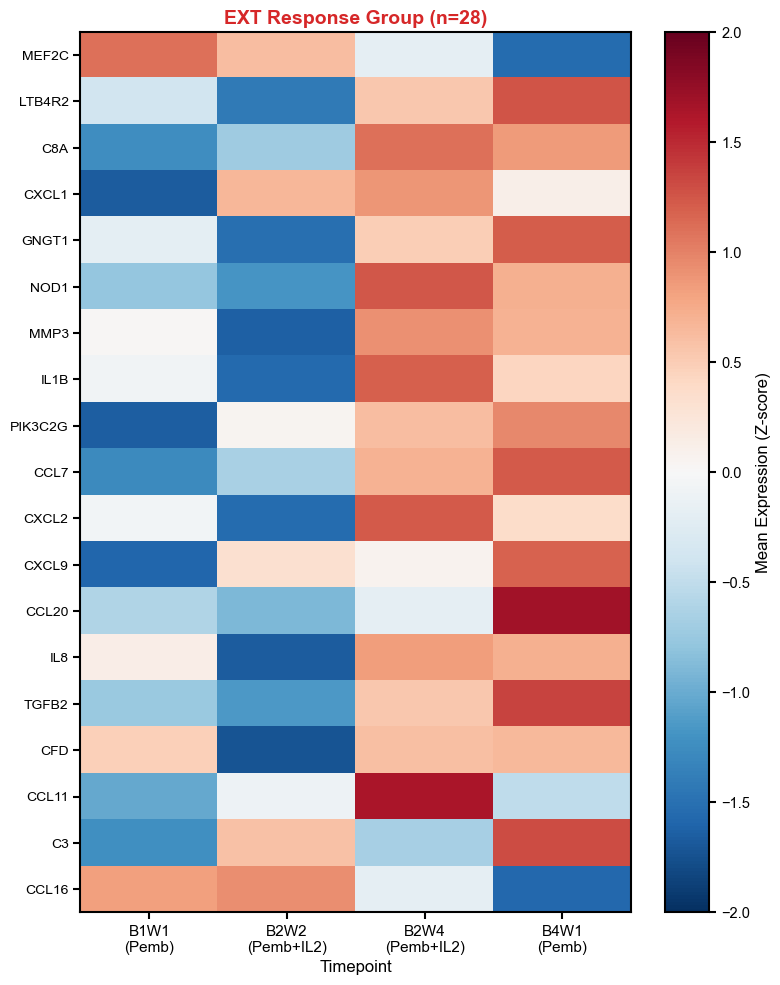

  Processing INT group...


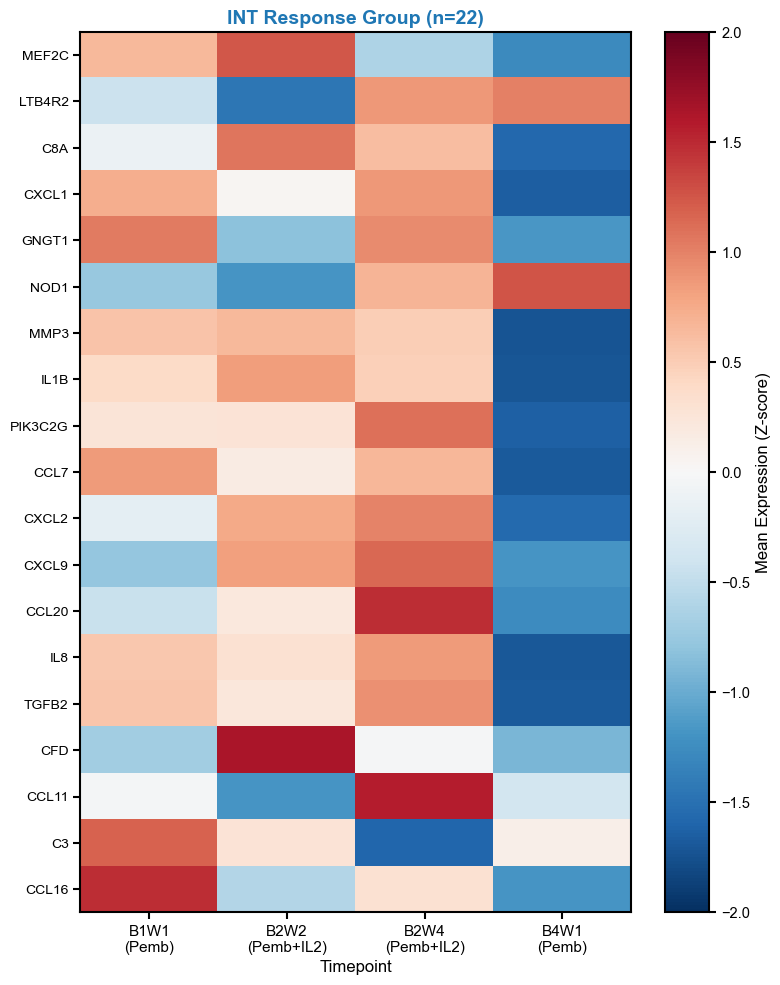

  Processing NON group...


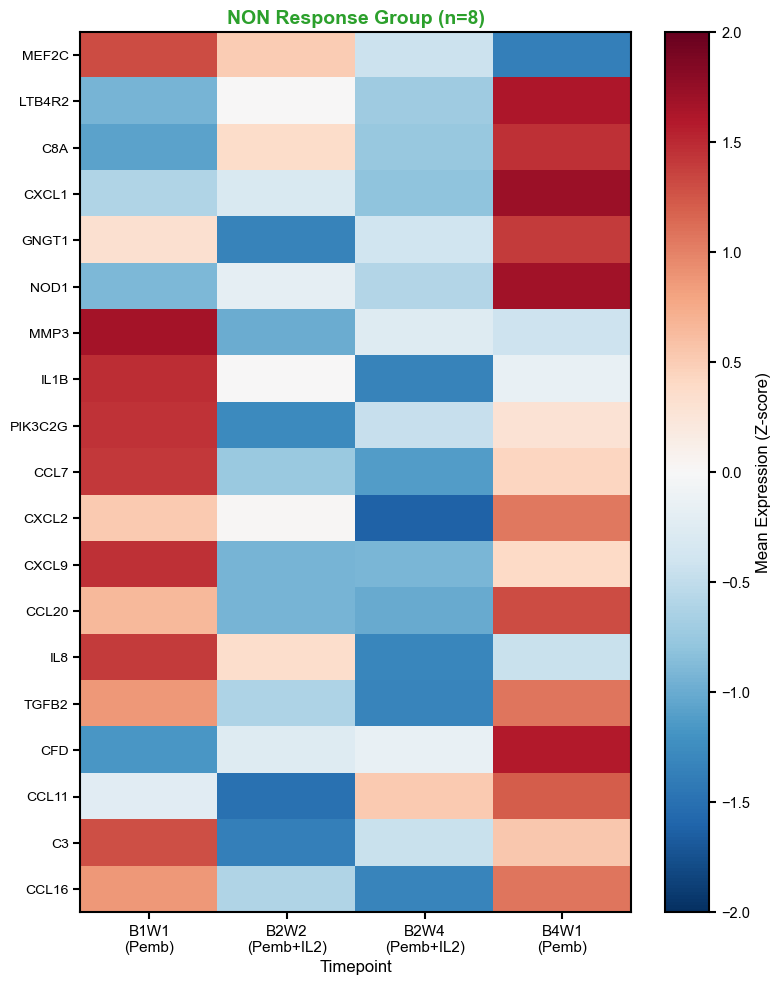

Individual Nanostring response heatmaps saved as PNG and PDF

Response group visualizations completed using 19 markers!
These are the SAME markers used in the main temporal analysis heatmap.
Data handling now matches the main analysis (allows some missing timepoints).

Nanostring response group analysis complete!
Note: The markers shown in these heatmaps should now match those in the main temporal analysis.


In [6]:
def create_separate_response_heatmaps(expression_data, sample_temporal_info, sample_to_response, significant_proteins, save_plots=True):
    """
    Create separate heatmaps for EXT, INT, and NON response groups - FIXED VERSION
    Uses the same data handling approach as the main temporal analysis
    """
    print("Creating separate response group heatmaps...")
    
    # Use specific timepoints instead of blocks
    unique_timepoints = ['B1W1', 'B2W2', 'B2W4', 'B4W1']
    
    # Define response colors (same as main analysis)
    response_colors = {'EXT': '#d62728', 'INT': '#1f77b4', 'NON': '#2ca02c'}
    
    response_groups = ['EXT', 'INT', 'NON']
    
    for response in response_groups:
        print(f"  Processing {response} group...")
        
        # Calculate mean expression by timepoint for this response group
        expression_matrix = []
        protein_labels = []
        
        for protein in significant_proteins[:20]:  # Top 20 proteins - SAME AS MAIN ANALYSIS
            if protein in expression_data.index:
                means = []
                sample_counts = []
                
                for timepoint in unique_timepoints:
                    samples = [s for s in sample_to_response.keys() if 
                              sample_to_response[s] == response and 
                              sample_temporal_info.get(s) and
                              sample_temporal_info[s]['timepoint'] == timepoint]
                    
                    if samples:
                        # Get values and handle NaN the same way as main analysis
                        raw_values = expression_data.loc[protein, samples]
                        
                        # Convert to numeric if needed, handling non-numeric data
                        if hasattr(raw_values, 'values'):
                            numeric_values = pd.to_numeric(raw_values.values, errors='coerce')
                        else:
                            numeric_values = pd.to_numeric(raw_values, errors='coerce')
                        
                        # Remove NaN values (same as main analysis)
                        valid_values = numeric_values[~np.isnan(numeric_values)]
                        
                        if len(valid_values) > 0:
                            means.append(np.mean(valid_values))
                            sample_counts.append(len(valid_values))
                        else:
                            means.append(np.nan)
                            sample_counts.append(0)
                    else:
                        means.append(np.nan)
                        sample_counts.append(0)
                
                # SAME INCLUSION CRITERIA AS MAIN ANALYSIS
                # Include proteins that have data for at least 2 timepoints (not requiring complete data)
                valid_timepoints = sum(1 for m in means if not np.isnan(m))
                if valid_timepoints >= 2:  # More lenient than original version
                    expression_matrix.append(means)
                    protein_labels.append(protein)
        
        if expression_matrix:
            expression_matrix = np.array(expression_matrix)
            
            # Z-score normalize each row (protein) - SAME AS MAIN ANALYSIS
            expression_matrix_z = np.zeros_like(expression_matrix)
            for i in range(len(protein_labels)):
                row = expression_matrix[i, :]
                valid_mask = ~np.isnan(row)
                if np.sum(valid_mask) > 1:  # Need at least 2 valid values for normalization
                    row_mean = np.nanmean(row)
                    row_std = np.nanstd(row)
                    if row_std > 0:
                        expression_matrix_z[i, :] = (row - row_mean) / row_std
                    else:
                        expression_matrix_z[i, :] = row - row_mean
                else:
                    expression_matrix_z[i, :] = row  # Keep original if can't normalize
            
            # Create timepoint labels (same as main analysis)
            timepoint_labels = []
            for timepoint in unique_timepoints:
                if timepoint == 'B1W1':
                    timepoint_labels.append('B1W1\n(Pemb)')
                elif timepoint in ['B2W2', 'B2W4']:
                    timepoint_labels.append(f'{timepoint}\n(Pemb+IL2)')
                elif timepoint == 'B4W1':
                    timepoint_labels.append('B4W1\n(Pemb)')
                else:
                    timepoint_labels.append(timepoint)
            
            # Create heatmap with improved styling (matching main analysis style)
            plt.figure(figsize=(8, max(10, len(protein_labels) * 0.5)))
            
            # Handle NaN values by masking them (same as main analysis approach)
            masked_data = np.ma.masked_where(np.isnan(expression_matrix_z), expression_matrix_z)
            
            im = plt.imshow(masked_data, aspect='auto', cmap='RdBu_r', interpolation='none', vmin=-2, vmax=2)
            
            # Add colorbar
            cbar = plt.colorbar(im, shrink=1.0)
            cbar.set_label('Mean Expression (Z-score)', fontsize=12)
            
            # Add axis labels
            plt.yticks(np.arange(len(protein_labels)), protein_labels, fontsize=10)
            plt.xticks(np.arange(len(unique_timepoints)), timepoint_labels, fontsize=11)
            
            # Add title with response group color
            n_samples = sum(1 for s in sample_to_response.values() if s == response)
            plt.title(f'{response} Response Group (n={n_samples})', 
                     fontweight='bold', color=response_colors[response], fontsize=14)
            
            plt.xlabel('Timepoint', fontsize=12)
            
            plt.tight_layout()
            
            if save_plots:
                plt.savefig(f'nanostring_heatmap_{response}.png', dpi=300, bbox_inches='tight')
                plt.savefig(f'nanostring_heatmap_{response}.pdf', bbox_inches='tight')
            
            plt.show()
        else:
            print(f"    No valid data found for {response} group")
    
    if save_plots:
        print("Individual Nanostring response heatmaps saved as PNG and PDF")

def create_response_summary_table_nanostring(expression_data, sample_temporal_info, sample_to_response):
    """
    Create a summary table showing sample counts by response group and timepoint for Nanostring
    """
    print("Creating response group summary table for Nanostring...")
    
    unique_timepoints = ['B1W1', 'B2W2', 'B2W4', 'B4W1']
    response_groups = ['EXT', 'INT', 'NON']
    
    # Create summary table
    summary_data = []
    
    for response in response_groups:
        for timepoint in unique_timepoints:
            samples = [s for s in sample_to_response.keys() if 
                      sample_to_response[s] == response and 
                      sample_temporal_info.get(s) and
                      sample_temporal_info[s]['timepoint'] == timepoint]
            
            summary_data.append({
                'Response_Group': response,
                'Timepoint': timepoint,
                'Sample_Count': len(samples)
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create pivot table for better display
    pivot_table = summary_df.pivot(index='Response_Group', columns='Timepoint', values='Sample_Count')
    pivot_table = pivot_table.fillna(0).astype(int)
    
    print("\nSample distribution by response group and timepoint:")
    print("="*60)
    print(pivot_table)
    
    # Save summary
    summary_df.to_csv('nanostring_response_summary.csv', index=False)
    pivot_table.to_csv('nanostring_response_pivot_summary.csv')
    
    print("\nSummary tables saved as CSV files")
    
    return summary_df, pivot_table

# EXECUTION CODE - Put this at the end of your main Nanostring analysis script
print("\n" + "="*60)
print("CREATING SEPARATE RESPONSE GROUP VISUALIZATIONS - NANOSTRING")
print("="*60)

# First, create summary table to understand data distribution
try:
    summary_df, pivot_table = create_response_summary_table_nanostring(filtered_data, sample_temporal_info, sample_to_response)
except Exception as e:
    print(f"Error creating summary table: {e}")

# USE THE SAME PROTEIN SELECTION METHOD AS THE MAIN ANALYSIS
print("\nUsing same marker selection method as main temporal analysis...")

try:
    # Check if we have temporal results from the main analysis
    if 'temporal_results_df' not in locals() or len(temporal_results_df) == 0:
        print("Warning: No temporal analysis results found. Using fallback marker selection...")
        # Fallback: use markers with highest variance
        numeric_data = filtered_data.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        marker_variances = numeric_data.var(axis=1, skipna=True).sort_values(ascending=False)
        min_samples_required = 5
        marker_sample_counts = numeric_data.count(axis=1)
        valid_markers = marker_sample_counts[marker_sample_counts >= min_samples_required].index
        visualization_markers = [m for m in marker_variances.index if m in valid_markers][:20]
        print(f"  Using fallback method: selected {len(visualization_markers)} markers with highest variance")
        
    else:
        # SAME MARKER SELECTION AS MAIN ANALYSIS
        print("Using temporal analysis results for marker selection...")
        
        # Find markers significant at multiple temporal levels
        marker_significance_counts = temporal_results_df[temporal_results_df['significant_raw']].groupby('Marker').size()
        multi_level_markers = marker_significance_counts[marker_significance_counts > 1].index.tolist()

        # Find markers with largest effect sizes across all analyses
        if 'abs_cohens_d' not in temporal_results_df.columns:
            temporal_results_df['abs_cohens_d'] = temporal_results_df['cohens_d'].abs()
        
        max_effect_markers = temporal_results_df.loc[
            temporal_results_df.groupby('Marker')['abs_cohens_d'].idxmax()
        ]
        top_effect_markers = max_effect_markers.nlargest(10, 'abs_cohens_d')['Marker'].tolist()

        # Combine for visualization (EXACTLY THE SAME AS MAIN ANALYSIS)
        visualization_markers = list(set(multi_level_markers + top_effect_markers))
        
        print(f"  Markers significant at multiple temporal levels: {len(multi_level_markers)}")
        print(f"  Top effect size markers: {len(top_effect_markers)}")
        print(f"  Combined unique markers for visualization: {len(visualization_markers)}")
        
        if len(multi_level_markers) > 0:
            print(f"  Multi-level significant markers: {multi_level_markers[:5]}")
        if len(top_effect_markers) > 0:
            print(f"  Top effect size markers: {top_effect_markers[:5]}")
    
    if len(visualization_markers) > 0:
        print(f"\nFinal marker list for visualization: {visualization_markers[:10]}...")
        
        # Create separate heatmaps for each response group using THE SAME MARKERS
        create_separate_response_heatmaps(
            filtered_data, sample_temporal_info, sample_to_response, visualization_markers
        )
        
        print(f"\nResponse group visualizations completed using {len(visualization_markers)} markers!")
        print("These are the SAME markers used in the main temporal analysis heatmap.")
        print("Data handling now matches the main analysis (allows some missing timepoints).")
        
    else:
        print("No markers available for visualization - check data availability.")

except Exception as e:
    print(f"Error in visualization: {e}")
    import traceback
    traceback.print_exc()

print("\nNanostring response group analysis complete!")
print("Note: The markers shown in these heatmaps should now match those in the main temporal analysis.")

In [7]:
def generate_manuscript_statistics(temporal_results_df, longitudinal_results, sample_temporal_info, sample_to_response):
    """
    Generate comprehensive statistics for manuscript writing
    """
    print("COMPREHENSIVE MANUSCRIPT STATISTICS")
    print("="*60)
    
    # Study demographics
    print("\nSTUDY DEMOGRAPHICS:")
    print("-"*30)
    
    # Patient and sample counts
    total_patients = len(set(info['subject'] for info in sample_temporal_info.values() if info))
    total_samples = len(sample_to_response)
    
    response_counts = {}
    for response in ['EXT', 'INT', 'NON']:
        response_counts[response] = sum(1 for r in sample_to_response.values() if r == response)
    
    print(f"Total patients: {total_patients}")
    print(f"Total samples: {total_samples}")
    print(f"Response distribution:")
    for response, count in response_counts.items():
        pct = (count/total_samples)*100
        print(f"  {response}: {count} samples ({pct:.1f}%)")
    
    # Temporal structure
    timepoint_counts = {}
    block_counts = {}
    for info in sample_temporal_info.values():
        if info:
            tp = info['timepoint']
            block = info['block']
            timepoint_counts[tp] = timepoint_counts.get(tp, 0) + 1
            block_counts[block] = block_counts.get(block, 0) + 1
    
    print(f"\nTemporal sampling:")
    print(f"  Timepoints: {sorted(timepoint_counts.keys())}")
    print(f"  Samples per timepoint: {dict(sorted(timepoint_counts.items()))}")
    print(f"  Treatment blocks represented: {sorted(block_counts.keys())}")
    
    # Longitudinal structure
    longitudinal_patients = {}
    for sample, info in sample_temporal_info.items():
        if info:
            patient = info['subject']
            if patient not in longitudinal_patients:
                longitudinal_patients[patient] = set()
            longitudinal_patients[patient].add(info['timepoint'])
    
    multi_tp_patients = sum(1 for tps in longitudinal_patients.values() if len(tps) > 1)
    avg_timepoints = np.mean([len(tps) for tps in longitudinal_patients.values()])
    
    print(f"  Patients with multiple timepoints: {multi_tp_patients}/{total_patients} ({multi_tp_patients/total_patients*100:.1f}%)")
    print(f"  Average timepoints per patient: {avg_timepoints:.1f}")
    
    # DIFFERENTIAL EXPRESSION RESULTS
    print("\nDIFFERENTIAL EXPRESSION ANALYSIS:")
    print("-"*40)
    
    # Cross-sectional results by analysis level
    for level in ['Timepoint', 'Phase', 'Block']:
        level_data = temporal_results_df[temporal_results_df['Analysis_Level'] == level]
        if len(level_data) > 0:
            n_comparisons = len(level_data)
            n_sig_raw = sum(level_data['significant_raw'])
            n_sig_fdr = sum(level_data['significant_FDR'])
            
            print(f"\n{level} Analysis:")
            print(f"  Total comparisons: {n_comparisons}")
            print(f"  Significant (p < 0.05): {n_sig_raw} ({n_sig_raw/n_comparisons*100:.1f}%)")
            print(f"  Significant (FDR < 0.05): {n_sig_fdr} ({n_sig_fdr/n_comparisons*100:.1f}%)")
            
            # Top significant markers
            if n_sig_raw > 0:
                sig_markers = level_data[level_data['significant_raw']].nsmallest(5, 'p_value')
                print(f"  Top 5 significant markers:")
                for _, row in sig_markers.iterrows():
                    print(f"    {row['Marker']} (p={row['p_value']:.2e}, FC={row['true_fold_change']:.2f})")
    
    # LONGITUDINAL ANALYSIS RESULTS
    if len(longitudinal_results) > 0:
        print("\nLONGITUDINAL ANALYSIS (Mixed Effects Models):")
        print("-"*50)
        
        total_proteins = len(longitudinal_results)
        
        # Model 1: Study week effects
        response_effects = sum(longitudinal_results['response_effect_p'] < 0.05)
        time_effects = sum(longitudinal_results['study_week_effect_p'] < 0.05)
        interaction_ext = sum(longitudinal_results['interaction_EXT_week_p'] < 0.05)
        interaction_int = sum(longitudinal_results['interaction_INT_week_p'] < 0.05)
        
        print(f"\nModel 1 - Continuous Time Effects ({total_proteins} proteins):")
        print(f"  Response group effects: {response_effects} ({response_effects/total_proteins*100:.1f}%)")
        print(f"  Time effects: {time_effects} ({time_effects/total_proteins*100:.1f}%)")
        print(f"  EXT×Time interactions: {interaction_ext} ({interaction_ext/total_proteins*100:.1f}%)")
        print(f"  INT×Time interactions: {interaction_int} ({interaction_int/total_proteins*100:.1f}%)")
        
        # Model 2: Treatment phase effects
        phase_il2 = sum(longitudinal_results['phase_Pemb_IL2_vs_Mono1_p'] < 0.05)
        phase_mono2 = sum(longitudinal_results['phase_Mono2_vs_Mono1_p'] < 0.05)
        
        print(f"\nModel 2 - Treatment Phase Effects:")
        print(f"  IL-2 phase vs Mono phase 1: {phase_il2} ({phase_il2/total_proteins*100:.1f}%)")
        print(f"  Mono phase 2 vs Mono phase 1: {phase_mono2} ({phase_mono2/total_proteins*100:.1f}%)")
        
        # Model 3: Treatment block effects
        block_effects = sum(longitudinal_results['block_effect_p'] < 0.05)
        print(f"\nModel 3 - Treatment Block Effects:")
        print(f"  Block effects: {block_effects} ({block_effects/total_proteins*100:.1f}%)")
        
        # Top time-responsive proteins
        time_responsive = longitudinal_results[longitudinal_results['study_week_effect_p'] < 0.05].nsmallest(10, 'study_week_effect_p')
        if len(time_responsive) > 0:
            print(f"\nTop 10 time-responsive proteins:")
            for _, row in time_responsive.iterrows():
                print(f"  {row['protein']} (p={row['study_week_effect_p']:.2e})")
    
    # EFFECT SIZES AND CLINICAL RELEVANCE
    print("\nEFFECT SIZES AND CLINICAL RELEVANCE:")
    print("-"*45)
    
    # Distribution of effect sizes
    all_cohens_d = temporal_results_df['cohens_d'].dropna()
    if len(all_cohens_d) > 0:
        large_effects = sum(abs(all_cohens_d) >= 0.8)
        medium_effects = sum((abs(all_cohens_d) >= 0.5) & (abs(all_cohens_d) < 0.8))
        small_effects = sum((abs(all_cohens_d) >= 0.2) & (abs(all_cohens_d) < 0.5))
        
        print(f"Effect size distribution (Cohen's d):")
        print(f"  Large effects (|d| ≥ 0.8): {large_effects}")
        print(f"  Medium effects (0.5 ≤ |d| < 0.8): {medium_effects}")
        print(f"  Small effects (0.2 ≤ |d| < 0.5): {small_effects}")
        print(f"  Mean |Cohen's d|: {np.mean(abs(all_cohens_d)):.2f}")
    
    # Fold change distribution
    all_fc = temporal_results_df['true_fold_change'].dropna()
    if len(all_fc) > 0:
        fc_up_15 = sum(all_fc >= 1.5)
        fc_down_15 = sum(all_fc <= 0.67)
        fc_up_2 = sum(all_fc >= 2.0)
        fc_down_2 = sum(all_fc <= 0.5)
        
        print(f"\nFold change distribution:")
        print(f"  ≥1.5-fold increased: {fc_up_15}")
        print(f"  ≥2.0-fold increased: {fc_up_2}")
        print(f"  ≤0.67-fold decreased: {fc_down_15}")
        print(f"  ≤0.5-fold decreased: {fc_down_2}")
    
    # PATHWAY AND FUNCTIONAL ANALYSIS
    print("\nBIOLOGICAL PATHWAYS REPRESENTED:")
    print("-"*40)
    
    # Define pathway categories
    pathways = {
        'Cytokines': ['IL1A', 'IL1B', 'IL6', 'IL8', 'IL10', 'IL15', 'TNF', 'IFNG'],
        'Chemokines': ['CCL2', 'CCL3', 'CCL4', 'CCL5', 'CCL7', 'CCL16', 'CCL20', 'CXCL1', 'CXCL2', 'CXCL9', 'CXCL10'],
        'Complement': ['C1QA', 'C3', 'C5', 'C8A', 'CFB'],
        'Matrix/Remodeling': ['MMP3', 'MMP9', 'TIMP1'],
        'Cell Surface': ['CD40', 'CD86', 'ICAM1', 'VCAM1'],
        'Innate Immunity': ['TLR2', 'TLR4', 'NOD1', 'NOD2']
    }
    
    # Check which pathways are represented in significant results
    sig_markers = set(temporal_results_df[temporal_results_df['significant_raw']]['Marker'].unique())
    
    for pathway, genes in pathways.items():
        pathway_genes = set(genes)
        sig_in_pathway = sig_markers.intersection(pathway_genes)
        if sig_in_pathway:
            print(f"  {pathway}: {len(sig_in_pathway)}/{len(pathway_genes)} genes significant")
            print(f"    {', '.join(sorted(sig_in_pathway))}")
    
    # STATISTICAL METHODS SUMMARY
    print("\nSTATISTICAL METHODS USED:")
    print("-"*30)
    print("• Wilcoxon rank-sum test for cross-sectional comparisons")
    print("• Linear mixed-effects models for longitudinal analysis")
    print("• Benjamini-Hochberg FDR correction for multiple testing")
    print("• Cohen's d and rank-biserial correlation for effect sizes")
    print("• Z-score normalization for visualization")
    
    return {
        'total_patients': total_patients,
        'total_samples': total_samples,
        'response_counts': response_counts,
        'longitudinal_patients': multi_tp_patients,
        'temporal_results': temporal_results_df,
        'longitudinal_results': longitudinal_results if len(longitudinal_results) > 0 else None
    }

# Generate manuscript statistics
manuscript_stats = generate_manuscript_statistics(
    temporal_results_df, longitudinal_results, sample_temporal_info, sample_to_response
)

# Save key results tables for manuscript
print("\nSaving manuscript tables...")

# Table 1: Study demographics
demo_data = {
    'Characteristic': ['Total patients', 'Total samples', 'Extreme responders', 'Intermediate responders', 'Non-responders'],
    'N': [manuscript_stats['total_patients'], manuscript_stats['total_samples']] + 
         [manuscript_stats['response_counts'][r] for r in ['EXT', 'INT', 'NON']],
    'Percentage': ['', ''] + [f"{manuscript_stats['response_counts'][r]/manuscript_stats['total_samples']*100:.1f}%" 
                             for r in ['EXT', 'INT', 'NON']]
}
pd.DataFrame(demo_data).to_csv('manuscript_table1_demographics.csv', index=False)

# Table 2: Significant markers summary
if len(temporal_results_df[temporal_results_df['significant_raw']]) > 0:
    sig_summary = temporal_results_df[temporal_results_df['significant_raw']].groupby('Analysis_Level').agg({
        'Marker': 'count',
        'p_value': ['min', 'median'],
        'true_fold_change': ['min', 'max'],
        'cohens_d': lambda x: np.mean(abs(x))
    }).round(4)
    sig_summary.to_csv('manuscript_table2_significant_markers.csv')

# Table 3: Top significant markers
top_markers = temporal_results_df[temporal_results_df['significant_raw']].nsmallest(20, 'p_value')[
    ['Marker', 'Analysis_Level', 'Temporal_Group', 'p_value', 'p_adjusted', 
     'log2_fold_change', 'true_fold_change', 'cohens_d']
].round(4)
top_markers.to_csv('manuscript_table3_top_markers.csv', index=False)

print("Manuscript tables saved:")
print("• manuscript_table1_demographics.csv")
print("• manuscript_table2_significant_markers.csv") 
print("• manuscript_table3_top_markers.csv")

COMPREHENSIVE MANUSCRIPT STATISTICS

STUDY DEMOGRAPHICS:
------------------------------
Total patients: 19
Total samples: 58
Response distribution:
  EXT: 28 samples (48.3%)
  INT: 22 samples (37.9%)
  NON: 8 samples (13.8%)

Temporal sampling:
  Timepoints: ['B1W1', 'B2W2', 'B2W4', 'B4W1']
  Samples per timepoint: {'B1W1': 15, 'B2W2': 16, 'B2W4': 17, 'B4W1': 10}
  Treatment blocks represented: [1, 2, 4]
  Patients with multiple timepoints: 19/19 (100.0%)
  Average timepoints per patient: 3.1

DIFFERENTIAL EXPRESSION ANALYSIS:
----------------------------------------

Timepoint Analysis:
  Total comparisons: 538
  Significant (p < 0.05): 9 (1.7%)
  Significant (FDR < 0.05): 0 (0.0%)
  Top 5 significant markers:
    CCL7 (p=1.21e-02, FC=1.43)
    MMP3 (p=1.21e-02, FC=1.27)
    C8A (p=2.42e-02, FC=1.48)
    CCL16 (p=2.42e-02, FC=1.28)
    CXCL1 (p=2.42e-02, FC=1.36)

Phase Analysis:
  Total comparisons: 269
  Significant (p < 0.05): 15 (5.6%)
  Significant (FDR < 0.05): 0 (0.0%)
  Top 5 

In [23]:
# Additional temporal analyses based on results

# 1. TIME-SPECIFIC BIOMARKER ANALYSIS
def analyze_time_responsive_proteins(longitudinal_results, temporal_results_df, filtered_data, sample_temporal_info, sample_to_response):
    """Analyze patterns in time-responsive proteins"""
    
    print("ANALYSIS 1: TIME-SPECIFIC BIOMARKER PATTERNS")
    print("="*50)
    
    # Get time-responsive proteins
    time_responsive = longitudinal_results[longitudinal_results['study_week_effect_p'] < 0.05]['protein'].tolist()
    phase_transition = longitudinal_results[longitudinal_results['phase_Mono2_vs_Mono1_p'] < 0.05]['protein'].tolist()
    
    print(f"Time-responsive proteins: {len(time_responsive)}")
    print(f"Phase-transition proteins: {len(phase_transition)}")
    print(f"Overlap: {len(set(time_responsive) & set(phase_transition))}")
    
    # Analyze temporal patterns
    protein_patterns = {}
    for protein in time_responsive:
        # Calculate expression at each timepoint
        timepoint_means = {}
        for tp in ['B1W1', 'B2W2', 'B2W4', 'B4W1']:
            samples = [s for s, info in sample_temporal_info.items() 
                      if info and info['timepoint'] == tp]
            if samples:
                values = filtered_data.loc[protein, samples].dropna()
                timepoint_means[tp] = values.mean()
        
        if len(timepoint_means) >= 3:
            # Classify pattern
            b1_mean = timepoint_means.get('B1W1', 0)
            b2w2_mean = timepoint_means.get('B2W2', 0)
            b2w4_mean = timepoint_means.get('B2W4', 0)
            b4_mean = timepoint_means.get('B4W1', 0)
            
            # Pattern classification
            il2_peak = max(b2w2_mean, b2w4_mean) > max(b1_mean, b4_mean)
            sustained = abs(b4_mean - b1_mean) > abs(max(b2w2_mean, b2w4_mean) - b1_mean)
            
            if il2_peak and not sustained:
                pattern = "IL2_peak"
            elif sustained:
                pattern = "sustained_change"
            elif b2w2_mean > b2w4_mean:
                pattern = "early_response"
            else:
                pattern = "progressive_change"
            
            protein_patterns[protein] = {
                'pattern': pattern,
                'means': timepoint_means,
                'fold_change_total': b4_mean / b1_mean if b1_mean > 0 else np.nan
            }
    
    # Summarize patterns
    pattern_counts = {}
    for data in protein_patterns.values():
        pattern = data['pattern']
        pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1
    
    print("\nTemporal pattern distribution:")
    for pattern, count in pattern_counts.items():
        print(f"  {pattern}: {count} proteins")
    
    # Top proteins by pattern
    for pattern in pattern_counts.keys():
        pattern_proteins = [p for p, data in protein_patterns.items() if data['pattern'] == pattern]
        print(f"\n{pattern} proteins: {pattern_proteins[:5]}")
    
    return protein_patterns, time_responsive, phase_transition

# 3. PATHWAY ENRICHMENT ANALYSIS
def pathway_enrichment_analysis(time_responsive, phase_transition):
    """Perform pathway enrichment on temporal protein sets"""
    
    print("\nANALYSIS 3: PATHWAY ENRICHMENT ANALYSIS")
    print("="*50)
    
    # Define pathway gene sets
    pathways = {
        'Cytokine_Signaling': ['IL1A', 'IL1B', 'IL2', 'IL4', 'IL5', 'IL6', 'IL7', 'IL8', 'IL9', 'IL10', 
                               'IL11', 'IL12A', 'IL12B', 'IL13', 'IL15', 'IL17A', 'IL18', 'IL21', 'IL22', 
                               'IL23A', 'TNF', 'IFNA1', 'IFNB1', 'IFNG', 'TGFB1', 'TGFB2', 'TGFB3'],
        'Chemokine_Signaling': ['CCL2', 'CCL3', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCL11', 'CCL13', 
                                'CCL16', 'CCL17', 'CCL19', 'CCL20', 'CCL21', 'CCL22', 'CCL23', 'CCL24', 
                                'CXCL1', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCL9', 'CXCL10'],
        'Complement_System': ['C1QA', 'C1QB', 'C1R', 'C1S', 'C2', 'C3', 'C4A', 'C5', 'C6', 'C7', 
                              'C8A', 'C8B', 'C9', 'CFB', 'CFD', 'MBL2', 'MASP1', 'MASP2'],
        'Innate_Immunity': ['TLR1', 'TLR2', 'TLR3', 'TLR4', 'TLR5', 'TLR6', 'TLR7', 'TLR8', 'TLR9', 
                            'NOD1', 'NOD2', 'NLRP3', 'MYD88', 'IRF1', 'IRF3', 'IRF5', 'IRF7'],
        'Matrix_Remodeling': ['MMP1', 'MMP2', 'MMP3', 'MMP7', 'MMP8', 'MMP9', 'MMP10', 'MMP12', 
                              'TIMP1', 'TIMP2', 'TIMP3', 'ADAM17', 'ADAMTS1'],
        'Cell_Adhesion': ['ICAM1', 'VCAM1', 'PECAM1', 'SELP', 'SELE', 'SELL', 'ITGB1', 'ITGB2'],
        'Apoptosis': ['CASP1', 'CASP3', 'CASP8', 'BCL2', 'BAX', 'FAS', 'FASLG', 'TNFRSF1A'],
        'T_Cell_Function': ['CD3E', 'CD4', 'CD8A', 'CD28', 'CTLA4', 'PDCD1', 'CD274', 'FOXP3'],
        'NK_Cell_Function': ['KLRK1', 'KLRD1', 'NCR1', 'GZMB', 'PRF1', 'IFNG'],
        'Metabolism': ['LDHA', 'PKM', 'GLUT1', 'HK2', 'PFKP', 'ALDOA']
    }
    
    def hypergeometric_test(gene_set, pathway_genes, universe_size=269):
        """Perform hypergeometric test for enrichment"""
        overlap = len(set(gene_set) & set(pathway_genes))
        gene_set_size = len(gene_set)
        pathway_size = len(pathway_genes)
        
        if overlap == 0:
            return 1.0, 0, []
        
        # Hypergeometric test
        p_value = stats.hypergeom.sf(overlap-1, universe_size, pathway_size, gene_set_size)
        fold_enrichment = (overlap / gene_set_size) / (pathway_size / universe_size)
        overlap_genes = list(set(gene_set) & set(pathway_genes))
        
        return p_value, fold_enrichment, overlap_genes
    
    # Test enrichment for time-responsive proteins
    print("Time-responsive protein enrichment:")
    time_enrichment = {}
    for pathway, genes in pathways.items():
        p_val, fold_enrich, overlap = hypergeometric_test(time_responsive, genes)
        if len(overlap) > 0:
            time_enrichment[pathway] = {
                'p_value': p_val,
                'fold_enrichment': fold_enrich,
                'overlap_count': len(overlap),
                'overlap_genes': overlap
            }
            print(f"  {pathway}: {len(overlap)} genes, p={p_val:.3f}, FC={fold_enrich:.2f}")
            if p_val < 0.05:
                print(f"    Genes: {', '.join(overlap)}")
    
    # Test enrichment for phase-transition proteins
    print("\nPhase-transition protein enrichment:")
    phase_enrichment = {}
    for pathway, genes in pathways.items():
        p_val, fold_enrich, overlap = hypergeometric_test(phase_transition, genes)
        if len(overlap) > 0:
            phase_enrichment[pathway] = {
                'p_value': p_val,
                'fold_enrichment': fold_enrich,
                'overlap_count': len(overlap),
                'overlap_genes': overlap
            }
            print(f"  {pathway}: {len(overlap)} genes, p={p_val:.3f}, FC={fold_enrich:.2f}")
            if p_val < 0.05:
                print(f"    Genes: {', '.join(overlap)}")
    
    return time_enrichment, phase_enrichment

# 5. IL-2 RESPONSE SIGNATURE ANALYSIS
def il2_response_analysis(filtered_data, sample_temporal_info, sample_to_response, longitudinal_results):
    """Analyze acute IL-2 effects (B2W2 vs B2W4)"""
    
    print("\nANALYSIS 5: IL-2 RESPONSE SIGNATURE")
    print("="*40)
    
    # Compare B2W2 vs B2W4 for each response group
    il2_results = {}
    
    for response in ['EXT', 'INT', 'NON']:
        # Get samples for each IL-2 timepoint
        b2w2_samples = [s for s, info in sample_temporal_info.items() 
                       if info and info['timepoint'] == 'B2W2' and sample_to_response.get(s) == response]
        b2w4_samples = [s for s, info in sample_temporal_info.items() 
                       if info and info['timepoint'] == 'B2W4' and sample_to_response.get(s) == response]
        
        if len(b2w2_samples) >= 3 and len(b2w4_samples) >= 3:
            print(f"\n{response} group IL-2 response ({len(b2w2_samples)} vs {len(b2w4_samples)} samples):")
            
            protein_changes = []
            for protein in filtered_data.index:
                b2w2_vals = filtered_data.loc[protein, b2w2_samples].dropna()
                b2w4_vals = filtered_data.loc[protein, b2w4_samples].dropna()
                
                if len(b2w2_vals) >= 2 and len(b2w4_vals) >= 2:
                    # Paired t-test if same patients, otherwise unpaired
                    try:
                        stat, p_val = stats.ttest_ind(b2w4_vals, b2w2_vals)
                        mean_b2w2 = b2w2_vals.mean()
                        mean_b2w4 = b2w4_vals.mean()
                        fold_change = mean_b2w4 / mean_b2w2 if mean_b2w2 > 0 else np.nan
                        
                        protein_changes.append({
                            'protein': protein,
                            'p_value': p_val,
                            'fold_change': fold_change,
                            'log2_fc': np.log2(fold_change) if fold_change > 0 else np.nan,
                            'mean_b2w2': mean_b2w2,
                            'mean_b2w4': mean_b2w4
                        })
                    except:
                        continue
            
            # Sort by significance
            protein_changes_df = pd.DataFrame(protein_changes)
            if len(protein_changes_df) > 0:
                protein_changes_df = protein_changes_df.sort_values('p_value')
                
                # Apply FDR correction
                _, p_adj, _, _ = multipletests(protein_changes_df['p_value'], method='fdr_bh')
                protein_changes_df['p_adjusted'] = p_adj
                
                # Significant changes
                sig_changes = protein_changes_df[protein_changes_df['p_value'] < 0.05]
                print(f"  Significant changes (p<0.05): {len(sig_changes)}")
                
                if len(sig_changes) > 0:
                    print("  Top changing proteins:")
                    for _, row in sig_changes.head(5).iterrows():
                        direction = "↑" if row['fold_change'] > 1 else "↓"
                        print(f"    {row['protein']} {direction} (FC={row['fold_change']:.2f}, p={row['p_value']:.3f})")
                
                il2_results[response] = protein_changes_df
    
    # Cross-response comparison
    if len(il2_results) > 1:
        print("\nIL-2 response differences between groups:")
        # Find proteins that respond differently between EXT and NON
        if 'EXT' in il2_results and 'NON' in il2_results:
            ext_sig = set(il2_results['EXT'][il2_results['EXT']['p_value'] < 0.05]['protein'])
            non_sig = set(il2_results['NON'][il2_results['NON']['p_value'] < 0.05]['protein'])
            
            ext_specific = ext_sig - non_sig
            non_specific = non_sig - ext_sig
            shared = ext_sig & non_sig
            
            print(f"  EXT-specific IL-2 response: {len(ext_specific)} proteins")
            print(f"  NON-specific IL-2 response: {len(non_specific)} proteins")
            print(f"  Shared IL-2 response: {len(shared)} proteins")
            
            if ext_specific:
                print(f"  EXT-specific proteins: {list(ext_specific)[:5]}")
    
    return il2_results

# Run all analyses
print("RUNNING ADDITIONAL TEMPORAL ANALYSES")
print("="*60)

# Analysis 1: Time-specific patterns
protein_patterns, time_responsive, phase_transition = analyze_time_responsive_proteins(
    longitudinal_results, temporal_results_df, filtered_data, sample_temporal_info, sample_to_response
)

# Analysis 3: Pathway enrichment
time_enrichment, phase_enrichment = pathway_enrichment_analysis(time_responsive, phase_transition)

# Analysis 5: IL-2 response signature
il2_results = il2_response_analysis(filtered_data, sample_temporal_info, sample_to_response, longitudinal_results)

# Save results
print("\nSaving additional analysis results...")

# Save time-responsive protein patterns
pd.DataFrame.from_dict(protein_patterns, orient='index').to_csv('nanostring_time_patterns.csv')

# Save pathway enrichment results
if time_enrichment:
    pd.DataFrame.from_dict(time_enrichment, orient='index').to_csv('nanostring_pathway_enrichment_time.csv')
if phase_enrichment:
    pd.DataFrame.from_dict(phase_enrichment, orient='index').to_csv('nanostring_pathway_enrichment_phase.csv')

# Save IL-2 response results
for response, results in il2_results.items():
    results.to_csv(f'nanostring_il2_response_{response}.csv', index=False)

print("Additional analyses complete!")
print("\nFiles generated:")
print("- nanostring_time_patterns.csv")
print("- nanostring_pathway_enrichment_time.csv")
print("- nanostring_pathway_enrichment_phase.csv")
print("- nanostring_il2_response_[EXT/INT/NON].csv")

RUNNING ADDITIONAL TEMPORAL ANALYSES
ANALYSIS 1: TIME-SPECIFIC BIOMARKER PATTERNS
Time-responsive proteins: 51
Phase-transition proteins: 22
Overlap: 14

Temporal pattern distribution:
  sustained_change: 47 proteins
  IL2_peak: 4 proteins

sustained_change proteins: ['BCL6', 'C8B', 'CDC42', 'CFL1', 'CXCR1']

IL2_peak proteins: ['CSF1', 'KEAP1', 'MAPK14', 'TLR1']

ANALYSIS 3: PATHWAY ENRICHMENT ANALYSIS
Time-responsive protein enrichment:
  Cytokine_Signaling: 3 genes, p=0.920, FC=0.59
  Complement_System: 1 genes, p=0.980, FC=0.29
  Innate_Immunity: 4 genes, p=0.408, FC=1.24
  Apoptosis: 1 genes, p=0.819, FC=0.66

Phase-transition protein enrichment:
  Cytokine_Signaling: 1 genes, p=0.912, FC=0.45
  Complement_System: 2 genes, p=0.444, FC=1.36
  Innate_Immunity: 1 genes, p=0.776, FC=0.72
  NK_Cell_Function: 1 genes, p=0.404, FC=2.04

ANALYSIS 5: IL-2 RESPONSE SIGNATURE

EXT group IL-2 response (7 vs 8 samples):
  Significant changes (p<0.05): 18
  Top changing proteins:
    CCR3 ↑ (FC